## Predicting Flood Potential Based on Rain Fall for the San Lorenzo River Basin, California

ETL Step 1:  
- Extracting data from Stream Gage USGS 11160500 San Lorenzo at Big Trees for the time period 09/01/2014 to 09/01/2024.

  Stream Gage data was obtained through download via the [USGS for station 11160500]. River height in feet, and stream flow in cubic feet per second, measured every 15 minutes.

- Extracting precipitation data relative to the San Lorenzo River Watershed for the same time period, 09/01/2014 to 09/01/2024.
  Data was obtained from the [California Data Exchange Center, Department of Water Sources site]
  
  4 stations were identified that have hourly data readings in inches of rainfall:

| Location            | Code | Elevation | Latitude  | Longitude    | County     | Agency                              |
|---------------------|------|-----------|-----------|--------------|------------|-------------------------------------|
| BEN LOMOND (CDF)     | BLO  | 2630      | 37.132000 | -122.169998  | SANTA CRUZ | CA Dept of Forestry and Fire Protection |
| SCHULTIES RD         | SCH  | 1400      | 37.132999 | -121.969002  | SANTA CRUZ | Santa Cruz County                   |
| BOULDER CREEK        | BDC  | 800       | 37.141998 | -122.163002  | SANTA CRUZ | Santa Cruz County                   |
| BEN LOMOND           | BLN  | 365       | 37.092999 | -122.074997  | SANTA CRUZ | Santa Cruz County                   |

BLO is the only station that has continuous measurements, the other three stations have event based measurements that are recorded based on a tipping point.






[USGS for station 11160500]: https://waterdata.usgs.gov/monitoring-location/11160500/#parameterCode=00065&period=P7D&showMedian=false
[California Data Exchange Center, Department of Water Sources site]: https://cdec.water.ca.gov/dynamicapp/wsSensorData

In [62]:
# Import dependencies
import pandas as pd 

Extracting the Stream Gage data to a Pandas data frame

In [63]:
# Define the file path 
file_path = 'Resources/BigTrees11160500_9_2014_9_2024.txt'

# Skip the header rows and load the data into a DataFrame
stream = pd.read_csv(file_path, sep='\t', comment='#', skiprows=28, header=0)

# Rename the columns
stream.columns = ['agency', 'site_no', 'datetime', 'time_zone', 'gage_height', 'approval_code']

# Convert the 'datetime' column to datetime type for easier manipulation
stream['datetime'] = pd.to_datetime(stream['datetime'])

# Display the DataFrame
print(stream.head())

  agency   site_no            datetime time_zone  gage_height approval_code
0   USGS  11160500 2014-09-01 00:00:00       PDT         2.69             A
1   USGS  11160500 2014-09-01 00:15:00       PDT         2.69             A
2   USGS  11160500 2014-09-01 00:30:00       PDT         2.69             A
3   USGS  11160500 2014-09-01 00:45:00       PDT         2.69             A
4   USGS  11160500 2014-09-01 01:00:00       PDT         2.69             A


In [64]:
# Define the path for the new CSV output
output_csv = 'Outputs/transformed_stream_gage_data.csv'

# Save the DataFrame to a new CSV file
stream.to_csv(output_csv, index=False)

print(f"Data has been saved to {output_csv}")

Data has been saved to Outputs/transformed_stream_gage_data.csv


Transform date to have only one measurement per hour to match the rain data

In [65]:
# Convert the 'datetime' column to datetime format if it exists
if 'datetime' in stream.columns:
    stream['datetime'] = pd.to_datetime(stream['datetime'], errors='coerce')

# Extract the date and hour from the 'datetime' column
stream['date_hour'] = stream['datetime'].dt.floor('h')

# Group by the date and hour and get the max gage height for each hour
max_height_per_hour = stream.groupby('date_hour').agg({'gage_height': 'max'}).reset_index()

# Display the new DataFrame with the date, hour, and max height
print(max_height_per_hour.head())

# Define the path for the new CSV output
output_csv = 'Outputs/transformed_stream_gage_data_hourly.csv'

# Save the DataFrame to a new CSV file
max_height_per_hour.to_csv(output_csv, index=False)

print(f"Data has been saved to {output_csv}")


            date_hour  gage_height
0 2014-09-01 00:00:00         2.69
1 2014-09-01 01:00:00         2.69
2 2014-09-01 02:00:00         2.69
3 2014-09-01 03:00:00         2.68
4 2014-09-01 04:00:00         2.68
Data has been saved to Outputs/transformed_stream_gage_data_hourly.csv


Repeating the same process for the river flow data

In [66]:
# Define the file path 
file_path = 'Resources/BigTrees11160500_9_2014_9_2024_flow.txt'

# Skip the header rows and load the data into a DataFrame
# Skip rows with the description of column widths like '5s', '15s', etc.
stream_flow = pd.read_csv(file_path, sep='\t', comment='#', skiprows=[28, 29], header=0, dtype={'site_no': str, '14696_00060': float})

# Rename the columns for easier reference
stream_flow.columns = ['agency', 'site_no', 'datetime', 'time_zone', 'discharge', 'approval_code']

# Convert the 'datetime' column to datetime type for easier manipulation, ignoring errors
stream_flow['datetime'] = pd.to_datetime(stream['datetime'], errors='coerce')

# Display the DataFrame (first few rows)
print(stream_flow.head())

# Define the path for the new CSV output
output_csv = 'Outputs/transformed_stream_discharge_data.csv'

# Save the DataFrame to a new CSV file
stream_flow.to_csv(output_csv, index=False)

print(f"Data has been saved to {output_csv}")


  agency   site_no            datetime time_zone  discharge approval_code
0   USGS  11160500 2014-09-01 00:00:00       PDT       7.09             A
1   USGS  11160500 2014-09-01 00:15:00       PDT       7.09             A
2   USGS  11160500 2014-09-01 00:30:00       PDT       7.09             A
3   USGS  11160500 2014-09-01 00:45:00       PDT       7.09             A
4   USGS  11160500 2014-09-01 01:00:00       PDT       7.09             A
Data has been saved to Outputs/transformed_stream_discharge_data.csv


Get the Max flow value per hour

In [67]:
# Convert the 'datetime' column to datetime format if it exists
if 'datetime' in stream_flow.columns:
    stream_flow['datetime'] = pd.to_datetime(stream_flow['datetime'], errors='coerce')

# Extract the date and hour from the 'datetime' column
stream_flow['date_hour'] = stream_flow['datetime'].dt.floor('h')

# Group by the date and hour and get the max discharge for each hour
max_flow_per_hour = stream_flow.groupby('date_hour').agg({'discharge': 'max'}).reset_index()

# Display the new DataFrame with the date, hour, and max discharge
print(max_flow_per_hour.head())

# Define the path for the new CSV output
output_csv = 'Outputs/transformed_max_flow_data_hourly.csv'

# Save the DataFrame to a new CSV file
max_flow_per_hour.to_csv(output_csv, index=False)

print(f"Data has been saved to {output_csv}")

            date_hour  discharge
0 2014-09-01 00:00:00       7.09
1 2014-09-01 01:00:00       7.09
2 2014-09-01 02:00:00       7.09
3 2014-09-01 03:00:00       6.86
4 2014-09-01 04:00:00       6.86
Data has been saved to Outputs/transformed_max_flow_data_hourly.csv


Extracting rain data to Pandas data frame

In [68]:
# Load the Excel file
file_path = 'Resources/BLO_2.xlsx'

# Reading the Excel file to inspect sheet names and general structure
xls = pd.ExcelFile(file_path)

# Display the sheet names to understand how the data is organized
xls.sheet_names

/usr/local/Caskroom/miniforge/base/envs/flooding_model/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


['Sheet1']

In [69]:
# Since the file contains a single sheet 'Sheet1', let's load it and inspect the first few rows to understand the data structure.
rain_BLO = pd.read_excel(file_path, sheet_name='Sheet1')

# Drop the 'datetime' column
rain_BLO = rain_BLO.drop(columns=['DATE TIME'])

# Convert the 'obs_date' column to datetime
rain_BLO['OBS DATE'] = pd.to_datetime(rain_BLO['OBS DATE'], errors='coerce')

# Display the first few rows of the DataFrame to understand the structure
rain_BLO.head()

,STATION_ID,DURATION,SENSOR_NUMBER,SENS_TYPE,OBS DATE,VALUE,DATA_FLAG,UNITS
0,BLO,H,2,RAIN,2014-09-01 00:00:00,0.04,,INCHES
1,BLO,H,2,RAIN,2014-09-01 01:00:00,0.04,,INCHES
2,BLO,H,2,RAIN,2014-09-01 02:00:00,0.04,,INCHES
3,BLO,H,2,RAIN,2014-09-01 03:00:00,0.04,,INCHES
4,BLO,H,2,RAIN,2014-09-01 04:00:00,0.04,,INCHES


In [70]:
# Define the path for the new CSV output
output_csv = 'Outputs/transformed_BLO_rain_data_hourly.csv'

# Save the DataFrame to a new CSV file
rain_BLO.to_csv(output_csv, index=False)

print(f"Data has been saved to {output_csv}")

Data has been saved to Outputs/transformed_BLO_rain_data_hourly.csv


In [71]:
print(rain_BLO.dtypes)

STATION_ID               object
DURATION                 object
SENSOR_NUMBER             int64
SENS_TYPE                object
OBS DATE         datetime64[ns]
VALUE                   float64
DATA_FLAG                object
UNITS                    object
dtype: object


In [72]:
import pandas as pd

# Load the dataset
file_path = 'Outputs/transformed_BLO_rain_data_hourly.csv'
rain_BLO = pd.read_csv(file_path)

# Convert 'OBS DATE' to datetime format for easier manipulation
rain_BLO['OBS DATE'] = pd.to_datetime(rain_BLO['OBS DATE'])

# Drop unnecessary columns: 'SENSOR_NUMBER', 'SENS_TYPE', 'DURATION', 'DATA_FLAG', 'UNITS'
rain_BLO_cleaned = rain_BLO.drop(columns=['SENSOR_NUMBER', 'SENS_TYPE', 'DURATION', 'DATA_FLAG', 'UNITS'], errors='ignore')

# Calculate hourly rainfall increments (difference between consecutive hours)
rain_BLO_cleaned['Hourly Rainfall (inches)'] = rain_BLO_cleaned['VALUE'].diff().fillna(0)

# Ensure no negative rainfall (in case of sensor resets or data issues)
rain_BLO_cleaned['Hourly Rainfall (inches)'] = rain_BLO_cleaned['Hourly Rainfall (inches)'].apply(lambda x: x if x >= 0 else 0)

# Add a new column for the date (without time) to facilitate daily calculations
rain_BLO_cleaned['Date'] = rain_BLO_cleaned['OBS DATE'].dt.date

# Calculate cumulative daily rainfall, resetting at the start of each new day
rain_BLO_cleaned['Cumulative Daily Rainfall (inches)'] = rain_BLO_cleaned.groupby('Date')['Hourly Rainfall (inches)'].cumsum()

# Detect days with no rainfall
daily_rain = rain_BLO_cleaned.groupby('Date')['Cumulative Daily Rainfall (inches)'].max().reset_index()
daily_rain['No Rain'] = daily_rain['Cumulative Daily Rainfall (inches)'] == 0

# Mark consecutive no-rain days
daily_rain['Consec No Rain'] = daily_rain['No Rain'].astype(int).groupby((daily_rain['No Rain'] != daily_rain['No Rain'].shift()).cumsum()).cumsum()

# Merge this info back into the hourly dataset
rain_BLO_cleaned = rain_BLO_cleaned.merge(daily_rain[['Date', 'Consec No Rain']], on='Date', how='left')

# Identify rain events, resetting when more than one consecutive day with no rain
rain_BLO_cleaned['Event ID'] = (rain_BLO_cleaned['Consec No Rain'] > 1).cumsum()

# Calculate cumulative rainfall per event and reset after the event ends
rain_BLO_cleaned['Cumulative Rainfall per Event (inches)'] = rain_BLO_cleaned.groupby('Event ID')['Hourly Rainfall (inches)'].cumsum()

# Reset the cumulative rainfall for event when there is no rain
rain_BLO_cleaned['Cumulative Rainfall per Event (inches)'] = rain_BLO_cleaned['Cumulative Rainfall per Event (inches)'].where(rain_BLO_cleaned['Consec No Rain'] == 0, 0)

# Drop unnecessary columns related to event tracking
rain_BLO_cleaned = rain_BLO_cleaned.drop(columns=['Consec No Rain', 'Event ID'], errors='ignore')

# Reorder columns for clarity
ordered_columns = ['STATION_ID', 'OBS DATE', 'VALUE', 'Hourly Rainfall (inches)', 
                   'Cumulative Daily Rainfall (inches)', 'Cumulative Rainfall per Event (inches)', 'Date']
rain_BLO_cleaned = rain_BLO_cleaned[ordered_columns]

# Save the final cleaned and processed data to a CSV file
rain_BLO_cleaned.to_csv('Outputs/BLO_Processed_Rainfall_Data_with_Events.csv', index=False)

# Display the final cleaned dataframe for a quick preview
print(rain_BLO_cleaned.head())


  STATION_ID            OBS DATE  VALUE  Hourly Rainfall (inches)  \
0        BLO 2014-09-01 00:00:00   0.04                       0.0   
1        BLO 2014-09-01 01:00:00   0.04                       0.0   
2        BLO 2014-09-01 02:00:00   0.04                       0.0   
3        BLO 2014-09-01 03:00:00   0.04                       0.0   
4        BLO 2014-09-01 04:00:00   0.04                       0.0   

   Cumulative Daily Rainfall (inches)  Cumulative Rainfall per Event (inches)  \
0                                 0.0                                     0.0   
1                                 0.0                                     0.0   
2                                 0.0                                     0.0   
3                                 0.0                                     0.0   
4                                 0.0                                     0.0   

         Date  
0  2014-09-01  
1  2014-09-01  
2  2014-09-01  
3  2014-09-01  
4  2014-09-01  


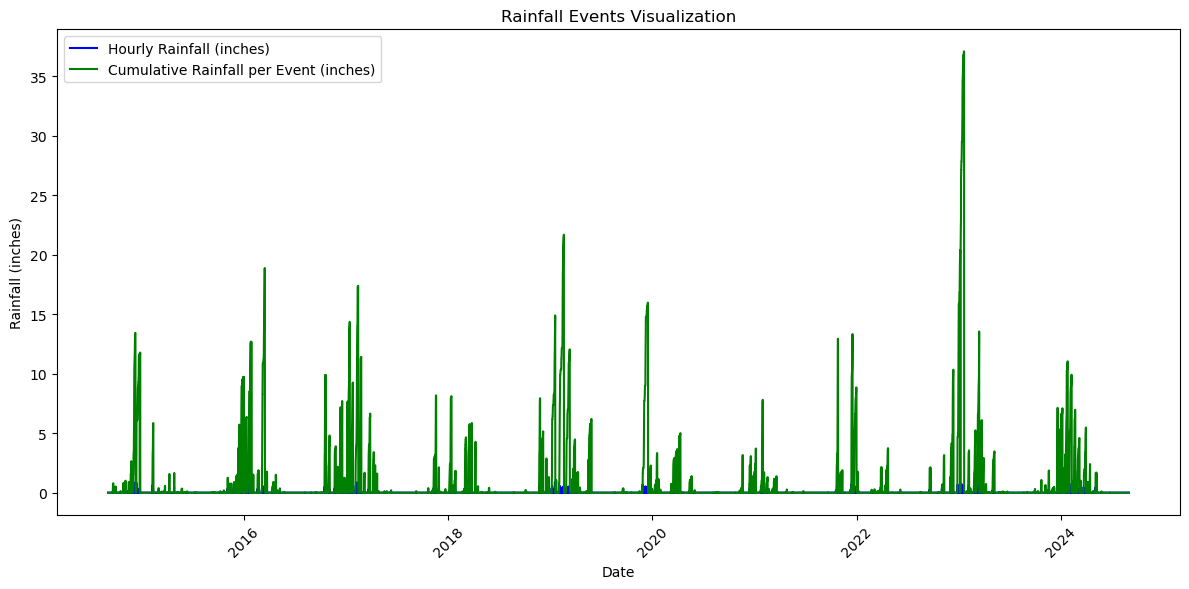

In [73]:
import matplotlib.pyplot as plt

# Create a plot with two lines: one for hourly rainfall and another for cumulative rainfall per event
plt.figure(figsize=(12, 6))

# Plot hourly rainfall
plt.plot(rain_BLO_cleaned['OBS DATE'], rain_BLO_cleaned['Hourly Rainfall (inches)'], label='Hourly Rainfall (inches)', color='blue')

# Plot cumulative rainfall per event
plt.plot(rain_BLO_cleaned['OBS DATE'], rain_BLO_cleaned['Cumulative Rainfall per Event (inches)'], label='Cumulative Rainfall per Event (inches)', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Rainfall (inches)')
plt.title('Rainfall Events Visualization')
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


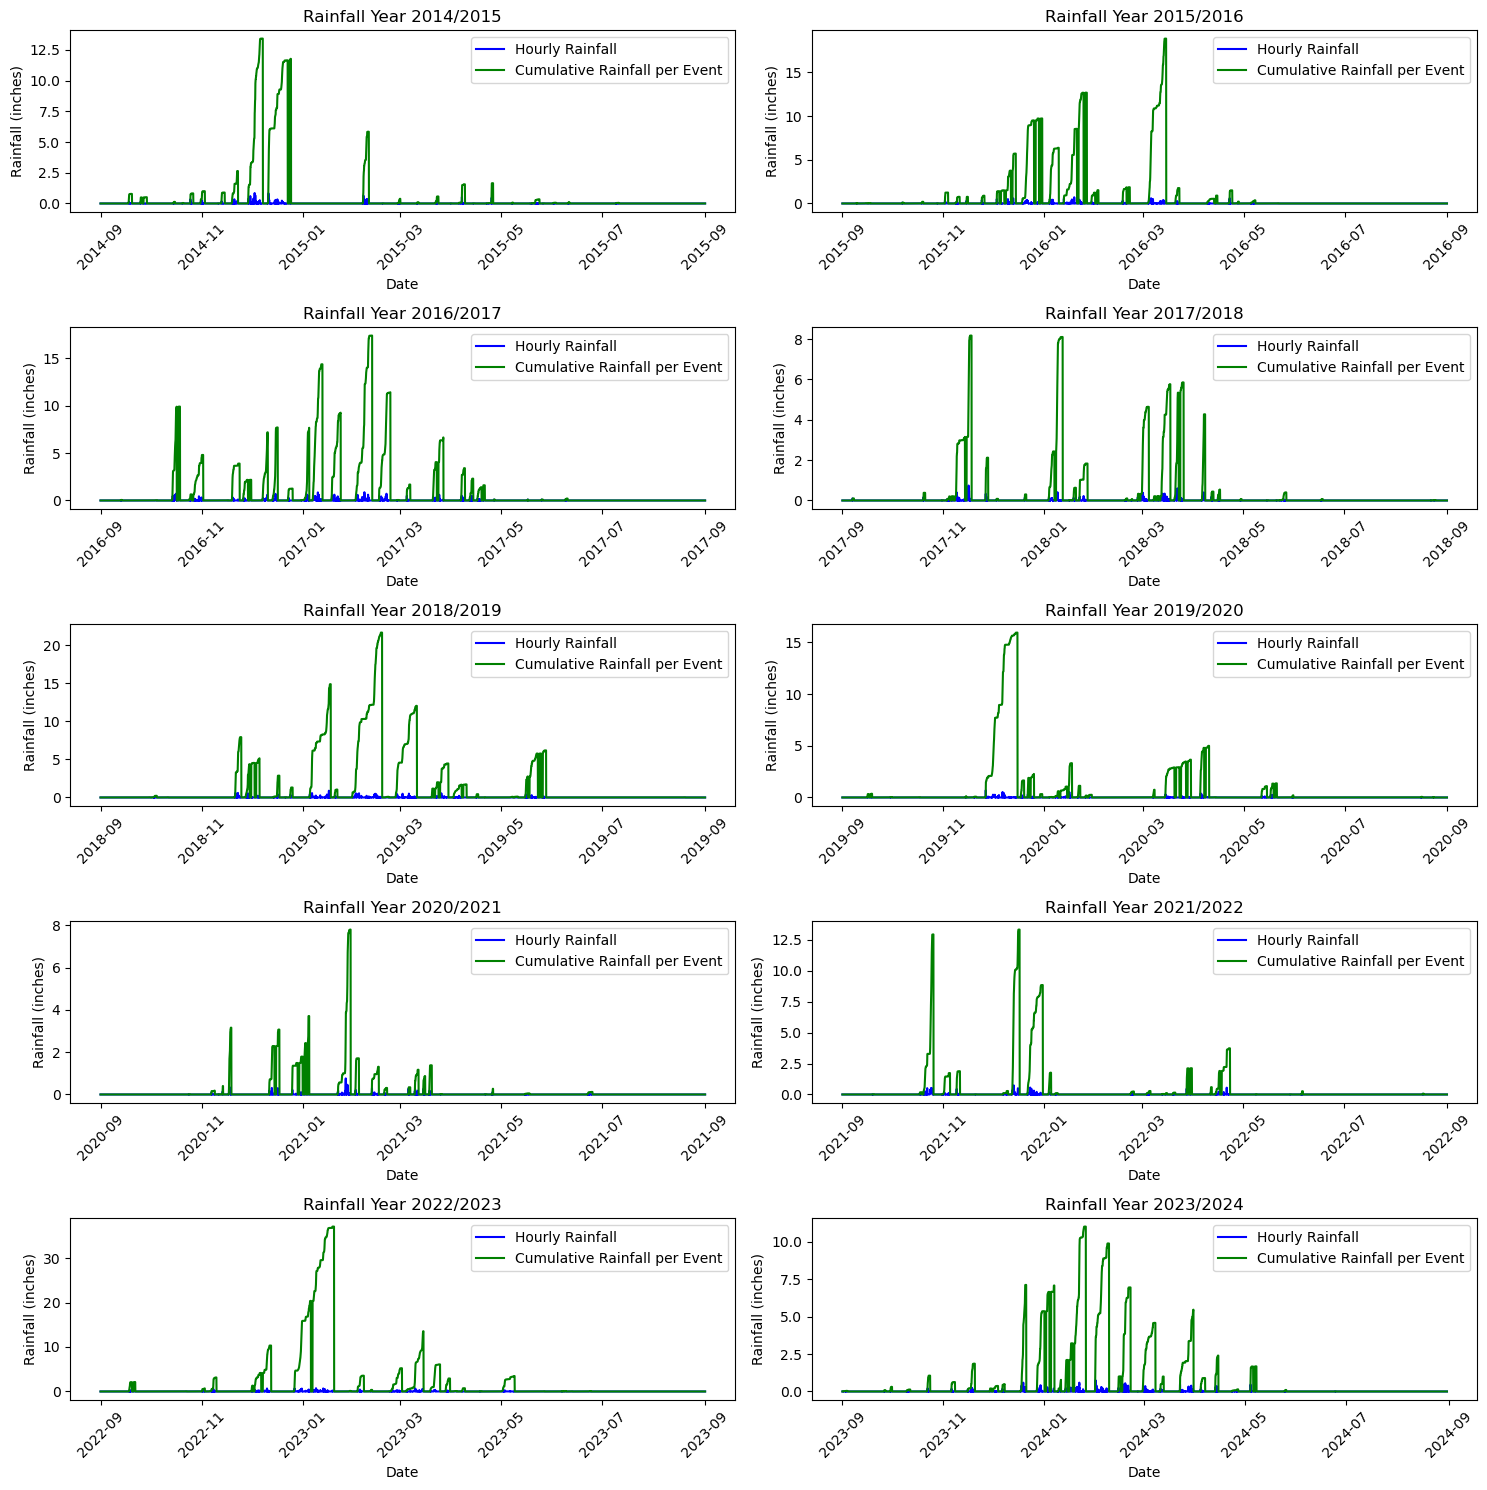

In [74]:
# Recreate the 'Rainfall Year' column to handle the KeyError
# Extract the month and year
rain_BLO_cleaned['Month'] = rain_BLO_cleaned['OBS DATE'].dt.month
rain_BLO_cleaned['Year'] = rain_BLO_cleaned['OBS DATE'].dt.year

# If the month is between September and December, keep the year as is
# If the month is between January and August, consider it as part of the previous rainfall year
rain_BLO_cleaned['Rainfall Year'] = rain_BLO_cleaned['Year']
rain_BLO_cleaned.loc[rain_BLO_cleaned['Month'] <= 8, 'Rainfall Year'] -= 1

# Filter out the year 2024/2025 and ensure we only plot up to 08/31/2024
end_date = pd.to_datetime('2024-08-31')
filtered_data = rain_BLO_cleaned[rain_BLO_cleaned['OBS DATE'] <= end_date]

# Update the unique years for plotting, ending at 2023/2024
years_to_plot = sorted(filtered_data['Rainfall Year'].unique())

# Define 10 years of data, excluding 2024/2025
years_to_plot = years_to_plot[:10]  # Only select 10 years

# Redefine the number of rows and columns for the 10-year plot
num_cols = 2
num_rows = 5  # 5 years per column

# Create a figure and axis for a page-sized plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot rainfall events for each rainfall year in a two-column layout
for i, year in enumerate(years_to_plot):
    ax = axes[i]
    
    # Filter data for the current rainfall year
    year_data = filtered_data[filtered_data['Rainfall Year'] == year]

    # Plot hourly rainfall
    ax.plot(year_data['OBS DATE'], year_data['Hourly Rainfall (inches)'], label='Hourly Rainfall', color='blue')

    # Plot cumulative rainfall per event
    ax.plot(year_data['OBS DATE'], year_data['Cumulative Rainfall per Event (inches)'], label='Cumulative Rainfall per Event', color='green')

    # Set title and labels for each subplot
    ax.set_title(f'Rainfall Year {year}/{year + 1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rainfall (inches)')
    ax.legend()

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

# Add some space between subplots and make the layout tight
plt.tight_layout()

# Display the final page-sized plot with 10 years of data
plt.show()


Load and clean Rain data for stations BDC, BLN, and SCH that only record with tipping point and compare with Daily measured rainfall to check for errors  

A sensor type where the field measuring device uses a calibrated bucket that tips when full of precipitation. The amount of precipitation at which the device tips is usually 0.04 inches. There are some gages that tip at 0.01 inches. The value usually accumulates or gets larger until it is reset. A reset may occur if a technician visits the site or it is near the beginning of the season. The dates that designate a season varies according to different agencies (ie. July-June, October-September). Generally, this sensor type is used for real-time collection duration of hourly or event data.

BDC Station

In [75]:
import pandas as pd

# Load the two Excel files
file_16_path = 'Resources/BDC_16.xlsx'
file_2_path = 'Resources/BDC_2.xlsx'

file_16 = pd.read_excel(file_16_path)
file_2 = pd.read_excel(file_2_path)

# Convert 'OBS DATE' in file_16 to datetime and round to nearest hour
file_16['OBS DATE'] = pd.to_datetime(file_16['OBS DATE'])
file_16['Rounded Date'] = file_16['OBS DATE'].dt.round('H')

# Calculate rainfall increments for file 16, ensuring no negative values
file_16['Rainfall'] = file_16['VALUE'].diff().fillna(0)
file_16.loc[file_16['Rainfall'] < 0, 'Rainfall'] = file_16['VALUE']  # Reset negative differences

# Calculate daily cumulative rainfall for File 16
file_16_daily = file_16.groupby(file_16['Rounded Date'].dt.date)['Rainfall'].sum().reset_index()
file_16_daily.columns = ['Date', 'Calculated Cumulative Rainfall (inches)']

# Convert 'OBS DATE' in file_2 to datetime
file_2['OBS DATE'] = pd.to_datetime(file_2['OBS DATE'])

# Extract relevant daily cumulative data from file 2
file_2_daily = file_2[['OBS DATE', 'VALUE']].dropna()
file_2_daily.columns = ['Date', 'Actual Cumulative Rainfall (inches)']

# Calculate daily rainfall for File 2, ensuring no negative values during reset conditions
file_2_daily['Daily Rainfall (inches)'] = file_2_daily['Actual Cumulative Rainfall (inches)'].diff().fillna(0)
file_2_daily.loc[file_2_daily['Actual Cumulative Rainfall (inches)'] < file_2_daily['Actual Cumulative Rainfall (inches)'].shift(1), 
                 'Daily Rainfall (inches)'] = file_2_daily['Actual Cumulative Rainfall (inches)']

# Ensure both 'Date' columns are of the same type
file_2_daily['Date'] = file_2_daily['Date'].dt.date

# Merge the two datasets on 'Date'
merged_data = pd.merge(file_16_daily, file_2_daily[['Date', 'Daily Rainfall (inches)']], on='Date', how='inner')

# Step 4: Identify discrepancies
merged_data['Discrepancy'] = merged_data['Calculated Cumulative Rainfall (inches)'] != merged_data['Daily Rainfall (inches)']

# Display the merged data with calculated discrepancies
print(merged_data)

# Save to CSV
merged_data.to_csv('Outputs/BDC_Daily_Rainfall_compare.csv', index=False)


/usr/local/Caskroom/miniforge/base/envs/flooding_model/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/Caskroom/miniforge/base/envs/flooding_model/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


            Date  Calculated Cumulative Rainfall (inches)  \
0     2015-10-23                                      0.0   
1     2015-10-24                                      0.0   
2     2015-10-25                                      0.0   
3     2015-10-26                                      0.0   
4     2015-10-27                                      0.0   
...          ...                                      ...   
2629  2024-08-16                                      0.0   
2630  2024-08-19                                      0.0   
2631  2024-08-23                                      0.0   
2632  2024-08-26                                      0.0   
2633  2024-08-31                                      0.0   

      Daily Rainfall (inches)  Discrepancy  
0                         0.0        False  
1                         0.0        False  
2                         0.0        False  
3                         0.0        False  
4                         0.0        False

/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_1517/2455478449.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  file_16['Rounded Date'] = file_16['OBS DATE'].dt.round('H')


Remove data from 16 file if discrepancy is greater than .25 inches

In [76]:
# Calculate the absolute difference between calculated and actual rainfall
merged_data['Difference'] = abs(merged_data['Calculated Cumulative Rainfall (inches)'] - merged_data['Daily Rainfall (inches)'])

# Filter out days where the difference is greater than 0.25 inches
filtered_data = merged_data[merged_data['Difference'] <= 0.25]

# Get the dates to keep from the filtered dataset
dates_to_keep = filtered_data['Date'].unique()

# Convert 'OBS DATE' in file_16 to datetime and ensure it's compatible for filtering
file_16['Date'] = file_16['OBS DATE'].dt.date

# Filter the original 16 file to keep only rows that match the dates in 'dates_to_keep'
filtered_file_16 = file_16[file_16['Date'].isin(dates_to_keep)].copy()  # .copy() to avoid SettingWithCopyWarning

# Now, calculate cumulative hourly rainfall for each day in the filtered 16 file
filtered_file_16['Cumulative Daily Rainfall'] = filtered_file_16.groupby('Date')['Rainfall'].cumsum()

# Merge the daily rainfall back into the filtered file
daily_totals = filtered_file_16.groupby('Date')['Rainfall'].sum().reset_index()
daily_totals.columns = ['Date', 'Total Daily Rainfall']

# Merge the daily totals into the filtered 16 file
filtered_file_16 = pd.merge(filtered_file_16, daily_totals, on='Date')

# Drop the additional 'Date' column after filtering if needed
filtered_file_16 = filtered_file_16.drop(columns=['Date'])

# Set 'Rainfall' and 'Cumulative Daily Rainfall' to 0 if 'Total Daily Rainfall' is 0
filtered_file_16.loc[filtered_file_16['Total Daily Rainfall'] == 0, ['Rainfall', 'Cumulative Daily Rainfall']] = 0

# Save the result to a CSV file
filtered_file_16.to_csv('Outputs/BDC_cleaned_hourly_Rainfall.csv', index=False)


# Display the final dataset with cumulative hourly rainfall and total daily rainfall
print(filtered_file_16)



      STATION_ID DURATION  SENSOR_NUMBER SENS_TYPE         DATE TIME  \
0            BDC        E             16   RAINTIP  2015-10-23 00:52   
1            BDC        E             16   RAINTIP  2015-10-23 12:52   
2            BDC        E             16   RAINTIP  2015-10-24 00:52   
3            BDC        E             16   RAINTIP  2015-10-25 00:52   
4            BDC        E             16   RAINTIP  2015-10-25 12:52   
...          ...      ...            ...       ...               ...   
11304        BDC        E             16   RAINTIP  2024-08-19 01:49   
11305        BDC        E             16   RAINTIP  2024-08-19 13:49   
11306        BDC        E             16   RAINTIP  2024-08-23 13:49   
11307        BDC        E             16   RAINTIP  2024-08-26 13:49   
11308        BDC        E             16   RAINTIP  2024-08-31 13:49   

                 OBS DATE  VALUE DATA_FLAG   UNITS        Rounded Date  \
0     2015-10-23 00:52:00   0.31            INCHES 2015-10-23

In [77]:
import pandas as pd

# Load the dataset
file_path = 'Outputs/BDC_cleaned_hourly_Rainfall.csv' 
rainfall_data = pd.read_csv(file_path)

# Convert 'Rounded Date' and 'OBS DATE' to datetime for easier manipulation
rainfall_data['Rounded Date'] = pd.to_datetime(rainfall_data['Rounded Date'])
rainfall_data['OBS DATE'] = pd.to_datetime(rainfall_data['OBS DATE'])

# Drop unnecessary columns: 'SENSOR_NUMBER', 'SENS_TYPE', 'DURATION', 'DATA_FLAG', 'UNITS'
rainfall_data = rainfall_data.drop(columns=['SENSOR_NUMBER', 'SENS_TYPE', 'DURATION', 'DATA_FLAG', 'UNITS', 'Total Daily Rainfall'], errors='ignore')

# Recalculate the 'Day Difference' between consecutive rows
rainfall_data['Day Difference'] = rainfall_data['Rounded Date'].diff().dt.days.fillna(0)

# Define the new event logic:
# A new event starts if there is a gap of more than 1 day,
# But, do not start a new event if the zero rainfall is on the same day and is consecutive
rainfall_data['New Event'] = (rainfall_data['Day Difference'] > 1) | (
    (rainfall_data['Rainfall'] == 0) & (rainfall_data['Day Difference'] != 0))

# Ensure the Event ID increments properly when a new event starts
rainfall_data['Event ID'] = rainfall_data['New Event'].cumsum()

# Ensure no negative rainfall values are included
rainfall_data['Rainfall'] = rainfall_data['Rainfall'].apply(lambda x: max(x, 0))

# Calculate cumulative rainfall for each event, ensuring zeros within an event are included
rainfall_data['Cumulative Rainfall per Event'] = rainfall_data.groupby('Event ID')['Rainfall'].cumsum()

# Find where the gap is more than 5 days
large_gaps = rainfall_data[rainfall_data['Day Difference'] > 5]

# Create new rows for each gap, set the date to 3 days after the previous date and other values to zero
new_rows = []
for index, row in large_gaps.iterrows():
    # Calculate the new date 3 days after the previous row's date
    new_date = row['Rounded Date'] - pd.Timedelta(days=(row['Day Difference'] - 3))
    new_row = row.copy()
    new_row['Rounded Date'] = new_date
    new_row['OBS DATE'] = new_date.strftime('%Y-%m-%d %H:%M:%S')  # Update 'OBS DATE'
    new_row['Rainfall'] = 0
    new_row['Cumulative Rainfall per Event'] = 0
    new_rows.append(new_row)

# Convert new_rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the original dataframe and the new rows dataframe
rainfall_data_with_inserts = pd.concat([rainfall_data, new_rows_df], ignore_index=True)

# Sort by 'OBS DATE' after ensuring 'OBS DATE' is treated as datetime
rainfall_data_with_inserts['OBS DATE'] = pd.to_datetime(rainfall_data_with_inserts['OBS DATE'])
rainfall_data_with_inserts = rainfall_data_with_inserts.sort_values(by='OBS DATE')

# Clean up temporary columns
rainfall_data_cleaned = rainfall_data_with_inserts.drop(columns=['Day Difference', 'New Event'], errors='ignore')

# Save the processed dataframe to a CSV file
output_file_path = 'Outputs/BDC_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv'
rainfall_data_cleaned.to_csv(output_file_path, index=False)

# Display a portion of the cleaned dataframe for review (optional)
print(rainfall_data_cleaned.head())


  STATION_ID         DATE TIME            OBS DATE  VALUE        Rounded Date  \
0        BDC  2015-10-23 00:52 2015-10-23 00:52:00   0.31 2015-10-23 01:00:00   
1        BDC  2015-10-23 12:52 2015-10-23 12:52:00   0.31 2015-10-23 13:00:00   
2        BDC  2015-10-24 00:52 2015-10-24 00:52:00   0.31 2015-10-24 01:00:00   
3        BDC  2015-10-25 00:52 2015-10-25 00:52:00   0.31 2015-10-25 01:00:00   
4        BDC  2015-10-25 12:52 2015-10-25 12:52:00   0.31 2015-10-25 13:00:00   

   Rainfall  Cumulative Daily Rainfall  Event ID  \
0       0.0                        0.0         0   
1       0.0                        0.0         0   
2       0.0                        0.0         0   
3       0.0                        0.0         1   
4       0.0                        0.0         1   

   Cumulative Rainfall per Event  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                        

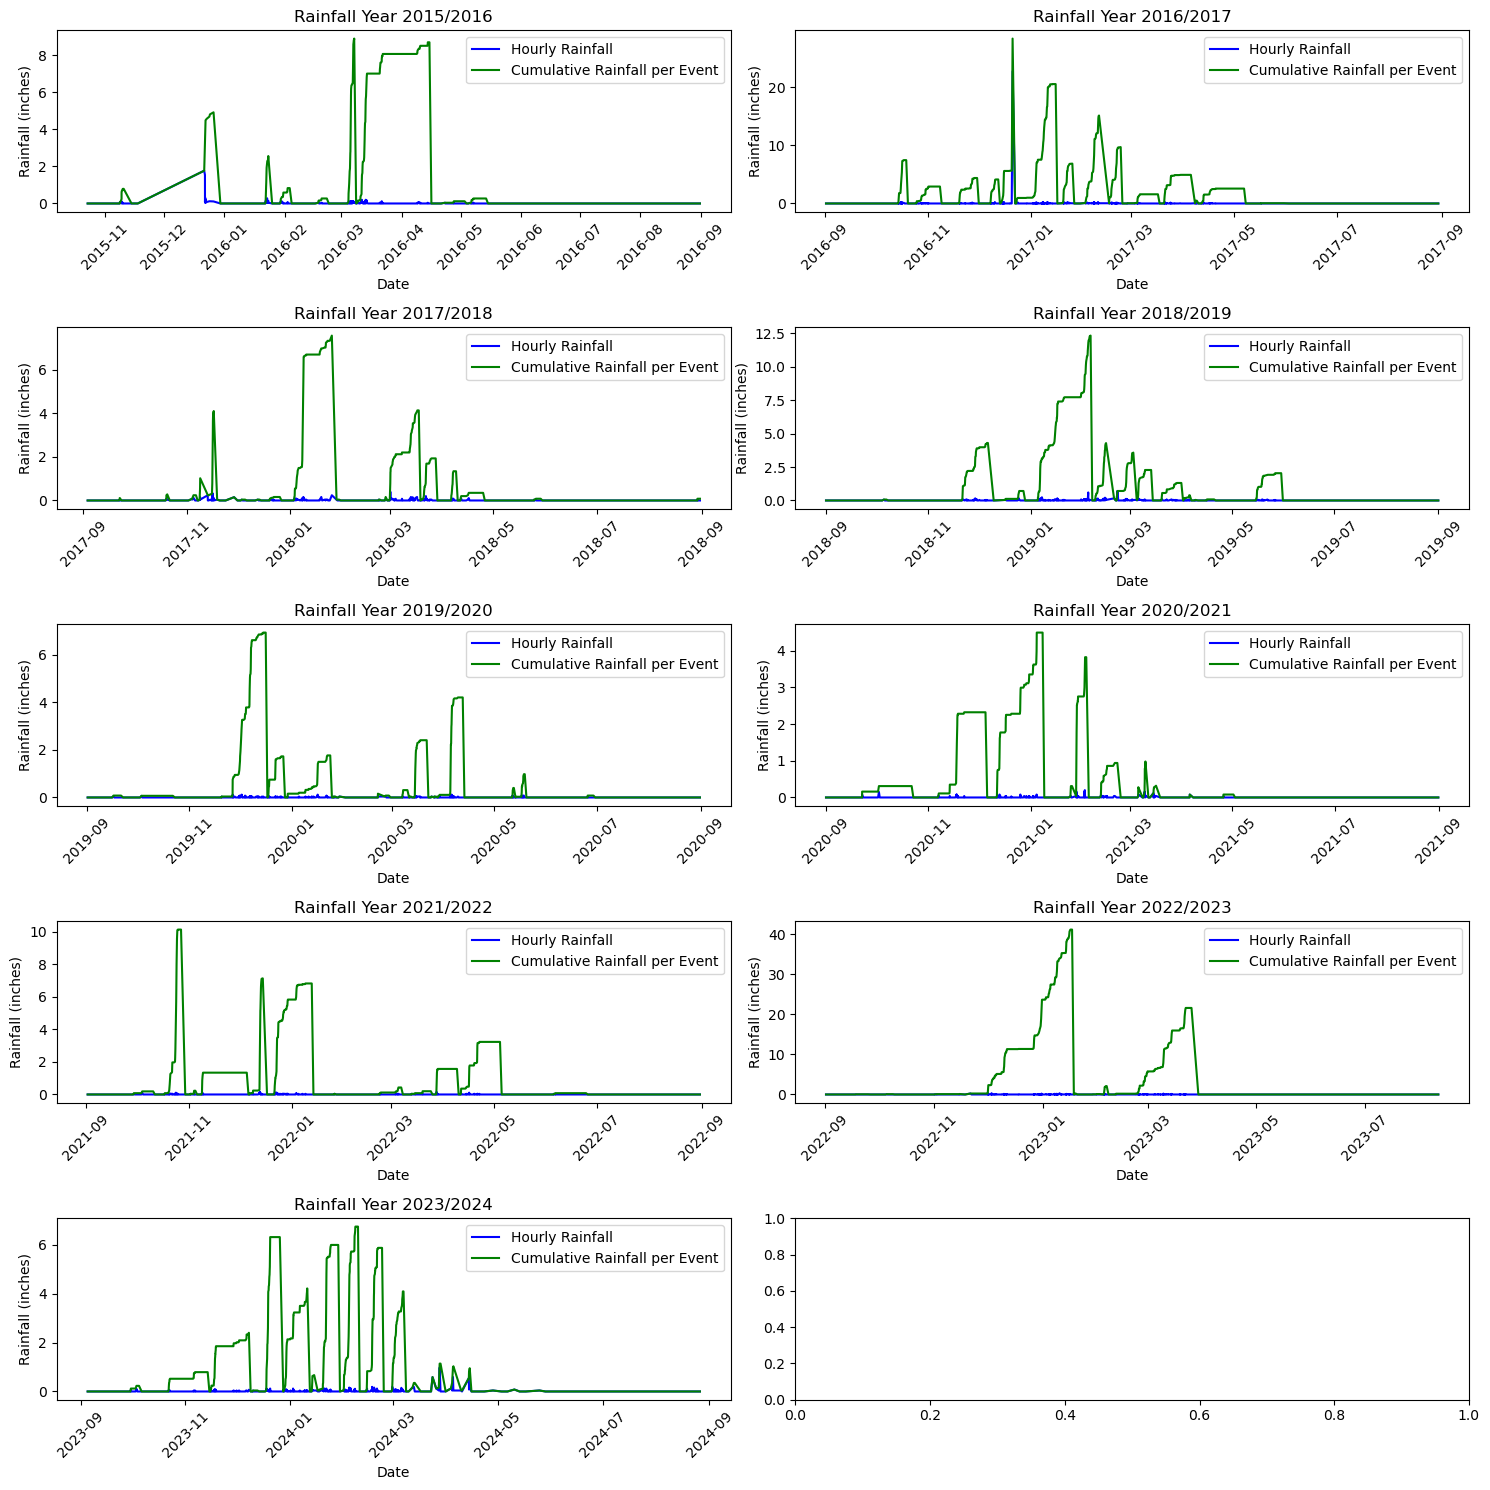

In [78]:
# Prepare the dataset for plotting, similar to the provided example, creating a 'Rainfall Year' and plotting.
# Load the dataset
file_path = 'Outputs/BDC_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv'
rainfall_data = pd.read_csv(file_path)

# Convert 'OBS DATE' to datetime for manipulation
rainfall_data['OBS DATE'] = pd.to_datetime(rainfall_data['OBS DATE'])

# Extract the month and year
rainfall_data['Month'] = rainfall_data['OBS DATE'].dt.month
rainfall_data['Year'] = rainfall_data['OBS DATE'].dt.year

# Create the 'Rainfall Year' column (September to August)
rainfall_data['Rainfall Year'] = rainfall_data['Year']
rainfall_data.loc[rainfall_data['Month'] <= 8, 'Rainfall Year'] -= 1

# Filter out the year 2024/2025 and ensure we only plot up to 08/31/2024
end_date = pd.to_datetime('2024-08-31')
filtered_data = rainfall_data[rainfall_data['OBS DATE'] <= end_date]

# Update the unique years for plotting, ending at 2023/2024
years_to_plot = sorted(filtered_data['Rainfall Year'].unique())

# Define 10 years of data, excluding 2024/2025
years_to_plot = years_to_plot[:9]  # Only select 10 years

# Redefine the number of rows and columns for the 10-year plot
num_cols = 2
num_rows = 5  # 5 years per column

# Create a figure and axis for a page-sized plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot rainfall events for each rainfall year in a two-column layout
for i, year in enumerate(years_to_plot):
    ax = axes[i]
    
    # Filter data for the current rainfall year
    year_data = filtered_data[filtered_data['Rainfall Year'] == year]

    # Plot hourly rainfall
    ax.plot(year_data['OBS DATE'], year_data['Rainfall'], label='Hourly Rainfall', color='blue')

    # Plot cumulative rainfall per event
    ax.plot(year_data['OBS DATE'], year_data['Cumulative Rainfall per Event'], label='Cumulative Rainfall per Event', color='green')

    # Set title and labels for each subplot
    ax.set_title(f'Rainfall Year {year}/{year + 1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rainfall (inches)')
    ax.legend()

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

# Add some space between subplots and make the layout tight
plt.tight_layout()

# Display the final page-sized plot with 10 years of data
plt.show()


BLN Station

In [79]:
import pandas as pd

# Load the two Excel files
file_16_path = ('Resources/BLN_16.xlsx')
file_2_path = ('Resources/BLN_2.xlsx')

file_16 = pd.read_excel(file_16_path)
file_2 = pd.read_excel(file_2_path)

# Convert 'OBS DATE' in file_16 to datetime and round to nearest hour
file_16['OBS DATE'] = pd.to_datetime(file_16['OBS DATE'])
file_16['Rounded Date'] = file_16['OBS DATE'].dt.round('H')

# Calculate rainfall increments for file 16, ensuring no negative values
file_16['Rainfall'] = file_16['VALUE'].diff().fillna(0)
file_16.loc[file_16['Rainfall'] < 0, 'Rainfall'] = file_16['VALUE']  # Reset negative differences

# Calculate daily cumulative rainfall for File 16
file_16_daily = file_16.groupby(file_16['Rounded Date'].dt.date)['Rainfall'].sum().reset_index()
file_16_daily.columns = ['Date', 'Calculated Cumulative Rainfall (inches)']

# Convert 'OBS DATE' in file_2 to datetime
file_2['OBS DATE'] = pd.to_datetime(file_2['OBS DATE'])

# Extract relevant daily cumulative data from file 2
file_2_daily = file_2[['OBS DATE', 'VALUE']].dropna()
file_2_daily.columns = ['Date', 'Actual Cumulative Rainfall (inches)']

# Calculate daily rainfall for File 2, ensuring no negative values during reset conditions
file_2_daily['Daily Rainfall (inches)'] = file_2_daily['Actual Cumulative Rainfall (inches)'].diff().fillna(0)
file_2_daily.loc[file_2_daily['Actual Cumulative Rainfall (inches)'] < file_2_daily['Actual Cumulative Rainfall (inches)'].shift(1), 
                 'Daily Rainfall (inches)'] = file_2_daily['Actual Cumulative Rainfall (inches)']

# Ensure both 'Date' columns are of the same type
file_2_daily['Date'] = file_2_daily['Date'].dt.date

# Merge the two datasets on 'Date'
merged_data = pd.merge(file_16_daily, file_2_daily[['Date', 'Daily Rainfall (inches)']], on='Date', how='inner')

# Step 4: Identify discrepancies
merged_data['Discrepancy'] = merged_data['Calculated Cumulative Rainfall (inches)'] != merged_data['Daily Rainfall (inches)']

# Display the merged data with calculated discrepancies
print(merged_data)

# Save to CSV
merged_data.to_csv('Outputs/BLN_Daily_Rainfall_compare.csv', index=False)

/usr/local/Caskroom/miniforge/base/envs/flooding_model/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/Caskroom/miniforge/base/envs/flooding_model/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


            Date  Calculated Cumulative Rainfall (inches)  \
0     2015-10-16                                      0.0   
1     2015-10-17                                      0.0   
2     2015-10-18                                      0.0   
3     2015-10-19                                      0.0   
4     2015-10-20                                      0.0   
...          ...                                      ...   
2296  2024-08-25                                      0.0   
2297  2024-08-26                                      0.0   
2298  2024-08-27                                      0.0   
2299  2024-08-29                                      0.0   
2300  2024-08-30                                      0.0   

      Daily Rainfall (inches)  Discrepancy  
0                         0.0        False  
1                         0.0        False  
2                         0.0        False  
3                         0.0        False  
4                         0.0        False

/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_1517/1938997430.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  file_16['Rounded Date'] = file_16['OBS DATE'].dt.round('H')


Remove data from 16 file if discrepancy is greater than .25 inches

In [80]:
# Calculate the absolute difference between calculated and actual rainfall
merged_data['Difference'] = abs(merged_data['Calculated Cumulative Rainfall (inches)'] - merged_data['Daily Rainfall (inches)'])

# Filter out days where the difference is greater than 0.25 inches
filtered_data = merged_data[merged_data['Difference'] <= 0.25]

# Get the dates to keep from the filtered dataset
dates_to_keep = filtered_data['Date'].unique()

# Convert 'OBS DATE' in file_16 to datetime and ensure it's compatible for filtering
file_16['Date'] = file_16['OBS DATE'].dt.date

# Filter the original 16 file to keep only rows that match the dates in 'dates_to_keep'
filtered_file_16 = file_16[file_16['Date'].isin(dates_to_keep)].copy()  # .copy() to avoid SettingWithCopyWarning

# Now, calculate cumulative hourly rainfall for each day in the filtered 16 file
filtered_file_16['Cumulative Daily Rainfall'] = filtered_file_16.groupby('Date')['Rainfall'].cumsum()

# Merge the daily rainfall back into the filtered file
daily_totals = filtered_file_16.groupby('Date')['Rainfall'].sum().reset_index()
daily_totals.columns = ['Date', 'Total Daily Rainfall']

# Merge the daily totals into the filtered 16 file
filtered_file_16 = pd.merge(filtered_file_16, daily_totals, on='Date')

# Drop the additional 'Date' column after filtering if needed
filtered_file_16 = filtered_file_16.drop(columns=['Date'])

# Set 'Rainfall' and 'Cumulative Daily Rainfall' to 0 if 'Total Daily Rainfall' is 0
filtered_file_16.loc[filtered_file_16['Total Daily Rainfall'] == 0, ['Rainfall', 'Cumulative Daily Rainfall']] = 0

# Save the result to a CSV file
filtered_file_16.to_csv('Outputs/BLN_cleaned_hourly_Rainfall.csv', index=False)


# Display the final dataset with cumulative hourly rainfall and total daily rainfall
print(filtered_file_16)



      STATION_ID DURATION  SENSOR_NUMBER SENS_TYPE         DATE TIME  \
0            BLN        E             16   RAINTIP  2015-10-16 11:08   
1            BLN        E             16   RAINTIP  2015-10-16 23:08   
2            BLN        E             16   RAINTIP  2015-10-17 11:08   
3            BLN        E             16   RAINTIP  2015-10-17 23:08   
4            BLN        E             16   RAINTIP  2015-10-18 11:08   
...          ...      ...            ...       ...               ...   
10587        BLN        E             16   RAINTIP  2024-08-25 12:03   
10588        BLN        E             16   RAINTIP  2024-08-26 12:03   
10589        BLN        E             16   RAINTIP  2024-08-27 12:03   
10590        BLN        E             16   RAINTIP  2024-08-29 00:03   
10591        BLN        E             16   RAINTIP  2024-08-30 12:03   

                 OBS DATE  VALUE DATA_FLAG   UNITS        Rounded Date  \
0     2015-10-16 11:08:00   0.00            INCHES 2015-10-16

In [81]:
import pandas as pd

# Load the dataset
file_path = 'Outputs/BLN_cleaned_hourly_Rainfall.csv' 
rainfall_data = pd.read_csv(file_path)

# Convert 'Rounded Date' and 'OBS DATE' to datetime for easier manipulation
rainfall_data['Rounded Date'] = pd.to_datetime(rainfall_data['Rounded Date'])
rainfall_data['OBS DATE'] = pd.to_datetime(rainfall_data['OBS DATE'])

# Drop unnecessary columns: 'SENSOR_NUMBER', 'SENS_TYPE', 'DURATION', 'DATA_FLAG', 'UNITS'
rainfall_data = rainfall_data.drop(columns=['SENSOR_NUMBER', 'SENS_TYPE', 'DURATION', 'DATA_FLAG', 'UNITS', 'Total Daily Rainfall'], errors='ignore')

# Recalculate the 'Day Difference' between consecutive rows
rainfall_data['Day Difference'] = rainfall_data['Rounded Date'].diff().dt.days.fillna(0)

# Define the new event logic:
# A new event starts if there is a gap of more than 1 day,
# But, do not start a new event if the zero rainfall is on the same day and is consecutive
rainfall_data['New Event'] = (rainfall_data['Day Difference'] > 1) | (
    (rainfall_data['Rainfall'] == 0) & (rainfall_data['Day Difference'] != 0))

# Ensure the Event ID increments properly when a new event starts
rainfall_data['Event ID'] = rainfall_data['New Event'].cumsum()

# Ensure no negative rainfall values are included
rainfall_data['Rainfall'] = rainfall_data['Rainfall'].apply(lambda x: max(x, 0))

# Calculate cumulative rainfall for each event, ensuring zeros within an event are included
rainfall_data['Cumulative Rainfall per Event'] = rainfall_data.groupby('Event ID')['Rainfall'].cumsum()

# Find where the gap is more than 5 days
large_gaps = rainfall_data[rainfall_data['Day Difference'] > 5]

# Create new rows for each gap, set the date to 3 days after the previous date and other values to zero
new_rows = []
for index, row in large_gaps.iterrows():
    # Calculate the new date 3 days after the previous row's date
    new_date = row['Rounded Date'] - pd.Timedelta(days=(row['Day Difference'] - 3))
    new_row = row.copy()
    new_row['Rounded Date'] = new_date
    new_row['OBS DATE'] = new_date.strftime('%Y-%m-%d %H:%M:%S')  # Update 'OBS DATE'
    new_row['Rainfall'] = 0
    new_row['Cumulative Rainfall per Event'] = 0
    new_rows.append(new_row)

# Convert new_rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the original dataframe and the new rows dataframe
rainfall_data_with_inserts = pd.concat([rainfall_data, new_rows_df], ignore_index=True)

# Sort by 'OBS DATE' after ensuring 'OBS DATE' is treated as datetime
rainfall_data_with_inserts['OBS DATE'] = pd.to_datetime(rainfall_data_with_inserts['OBS DATE'])
rainfall_data_with_inserts = rainfall_data_with_inserts.sort_values(by='OBS DATE')

# Clean up temporary columns
rainfall_data_cleaned = rainfall_data_with_inserts.drop(columns=['Day Difference', 'New Event'], errors='ignore')

# Save the processed dataframe to a CSV file
output_file_path = 'Outputs/BLN_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv'
rainfall_data_cleaned.to_csv(output_file_path, index=False)

# Display a portion of the cleaned dataframe for review (optional)
print(rainfall_data_cleaned.head())


  STATION_ID         DATE TIME            OBS DATE  VALUE        Rounded Date  \
0        BLN  2015-10-16 11:08 2015-10-16 11:08:00    0.0 2015-10-16 11:00:00   
1        BLN  2015-10-16 23:08 2015-10-16 23:08:00    0.0 2015-10-16 23:00:00   
2        BLN  2015-10-17 11:08 2015-10-17 11:08:00    0.0 2015-10-17 11:00:00   
3        BLN  2015-10-17 23:08 2015-10-17 23:08:00    0.0 2015-10-17 23:00:00   
4        BLN  2015-10-18 11:08 2015-10-18 11:08:00    0.0 2015-10-18 11:00:00   

   Rainfall  Cumulative Daily Rainfall  Event ID  \
0       0.0                        0.0         0   
1       0.0                        0.0         0   
2       0.0                        0.0         0   
3       0.0                        0.0         0   
4       0.0                        0.0         0   

   Cumulative Rainfall per Event  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                        

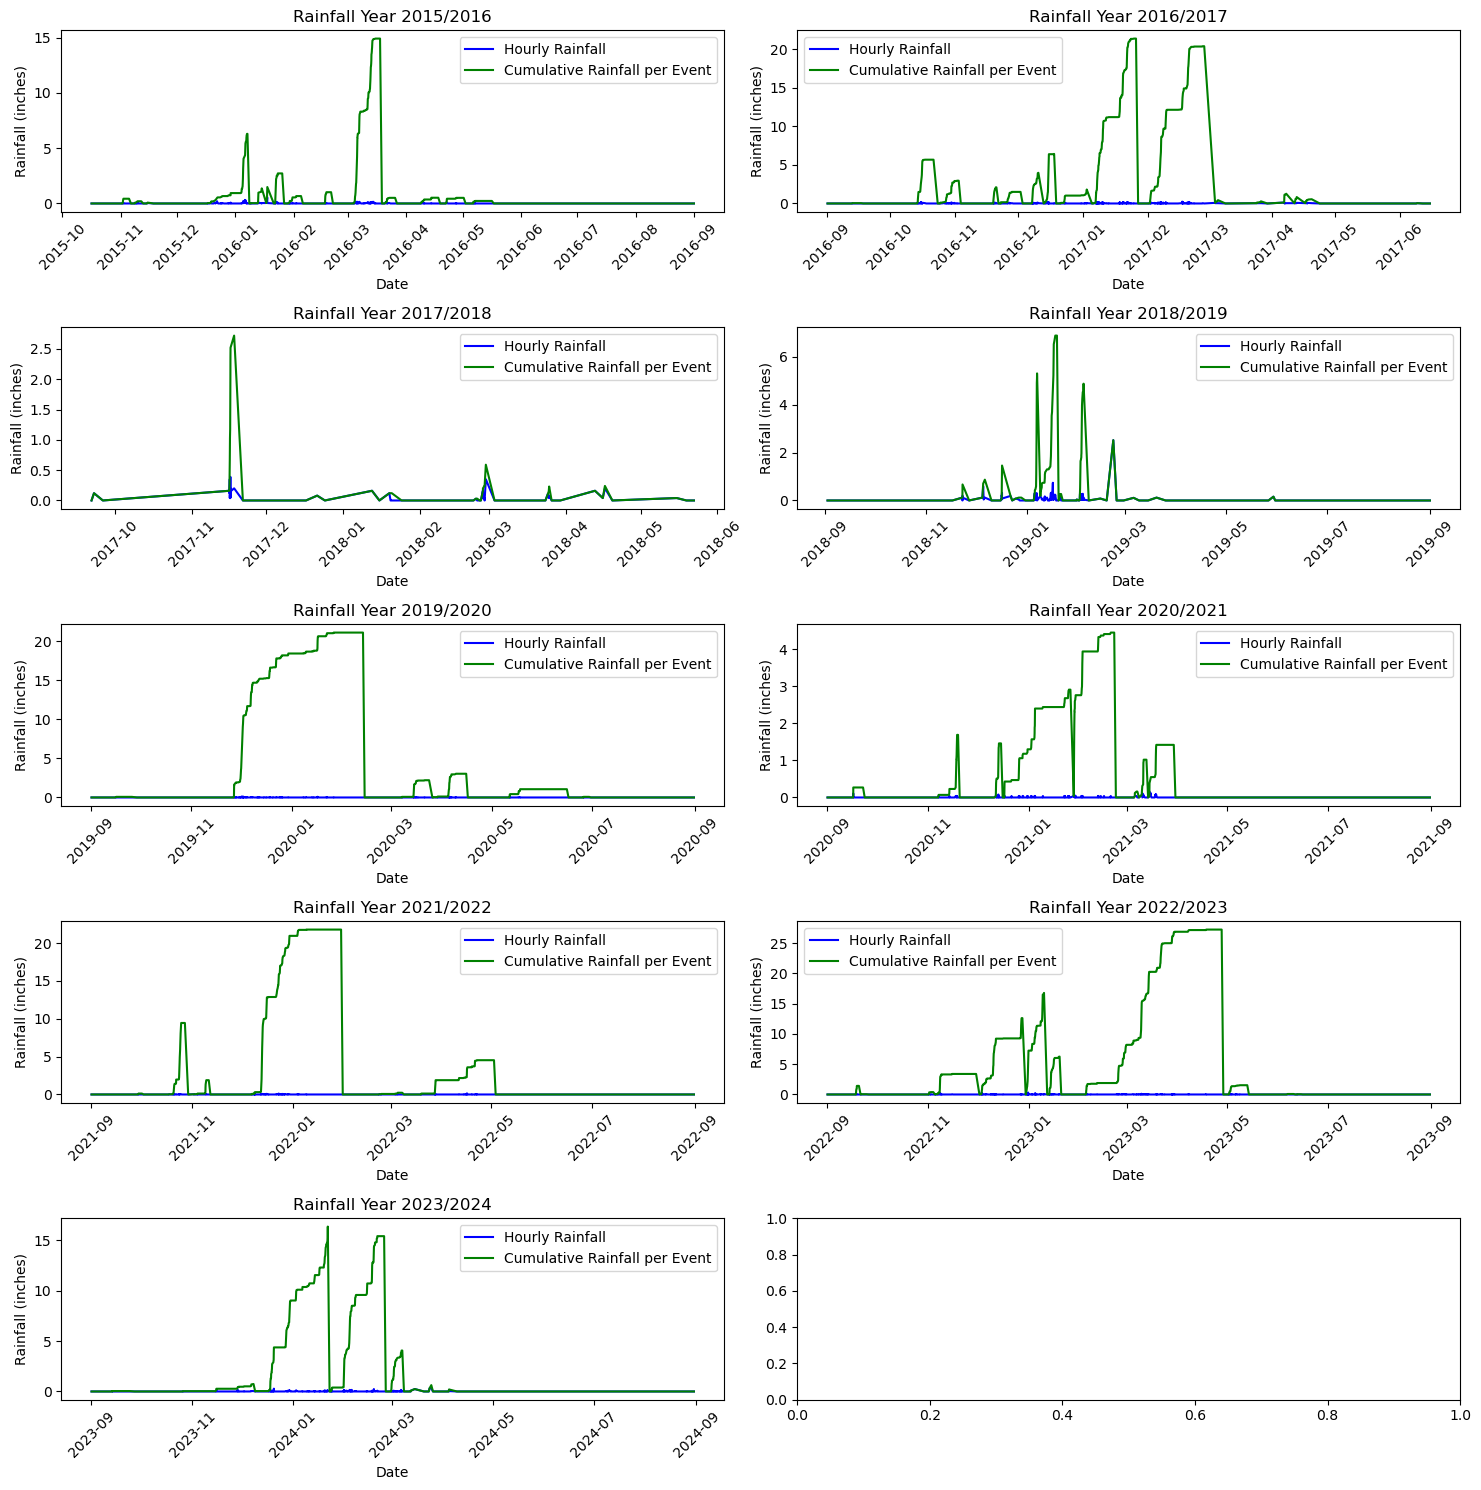

In [82]:
# Prepare the dataset for plotting, similar to the provided example, creating a 'Rainfall Year' and plotting.
# Load the dataset
file_path = 'Outputs/BLN_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv'
rainfall_data = pd.read_csv(file_path)

# Convert 'OBS DATE' to datetime for manipulation
rainfall_data['OBS DATE'] = pd.to_datetime(rainfall_data['OBS DATE'])

# Extract the month and year
rainfall_data['Month'] = rainfall_data['OBS DATE'].dt.month
rainfall_data['Year'] = rainfall_data['OBS DATE'].dt.year

# Create the 'Rainfall Year' column (September to August)
rainfall_data['Rainfall Year'] = rainfall_data['Year']
rainfall_data.loc[rainfall_data['Month'] <= 8, 'Rainfall Year'] -= 1

# Filter out the year 2024/2025 and ensure we only plot up to 08/31/2024
end_date = pd.to_datetime('2024-08-31')
filtered_data = rainfall_data[rainfall_data['OBS DATE'] <= end_date]

# Update the unique years for plotting, ending at 2023/2024
years_to_plot = sorted(filtered_data['Rainfall Year'].unique())

# Define 10 years of data, excluding 2024/2025
years_to_plot = years_to_plot[:9]  # Only select 10 years

# Redefine the number of rows and columns for the 10-year plot
num_cols = 2
num_rows = 5  # 5 years per column

# Create a figure and axis for a page-sized plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot rainfall events for each rainfall year in a two-column layout
for i, year in enumerate(years_to_plot):
    ax = axes[i]
    
    # Filter data for the current rainfall year
    year_data = filtered_data[filtered_data['Rainfall Year'] == year]

    # Plot hourly rainfall
    ax.plot(year_data['OBS DATE'], year_data['Rainfall'], label='Hourly Rainfall', color='blue')

    # Plot cumulative rainfall per event
    ax.plot(year_data['OBS DATE'], year_data['Cumulative Rainfall per Event'], label='Cumulative Rainfall per Event', color='green')

    # Set title and labels for each subplot
    ax.set_title(f'Rainfall Year {year}/{year + 1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rainfall (inches)')
    ax.legend()

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

# Add some space between subplots and make the layout tight
plt.tight_layout()

# Display the final page-sized plot with 10 years of data
plt.show()


SCH Station

In [83]:
import pandas as pd

# Load the two Excel files
file_16 = ('Resources/SCH_16.xlsx')
file_2 = ('Resources/SCH_2.xlsx')

file_16 = pd.read_excel(file_16_path)
file_2 = pd.read_excel(file_2_path)

# Convert 'OBS DATE' in file_16 to datetime and round to nearest hour
file_16['OBS DATE'] = pd.to_datetime(file_16['OBS DATE'])
file_16['Rounded Date'] = file_16['OBS DATE'].dt.round('H')

# Calculate rainfall increments for file 16, ensuring no negative values
file_16['Rainfall'] = file_16['VALUE'].diff().fillna(0)
file_16.loc[file_16['Rainfall'] < 0, 'Rainfall'] = file_16['VALUE']  # Reset negative differences

# Calculate daily cumulative rainfall for File 16
file_16_daily = file_16.groupby(file_16['Rounded Date'].dt.date)['Rainfall'].sum().reset_index()
file_16_daily.columns = ['Date', 'Calculated Cumulative Rainfall (inches)']

# Convert 'OBS DATE' in file_2 to datetime
file_2['OBS DATE'] = pd.to_datetime(file_2['OBS DATE'])

# Extract relevant daily cumulative data from file 2
file_2_daily = file_2[['OBS DATE', 'VALUE']].dropna()
file_2_daily.columns = ['Date', 'Actual Cumulative Rainfall (inches)']

# Calculate daily rainfall for File 2, ensuring no negative values during reset conditions
file_2_daily['Daily Rainfall (inches)'] = file_2_daily['Actual Cumulative Rainfall (inches)'].diff().fillna(0)
file_2_daily.loc[file_2_daily['Actual Cumulative Rainfall (inches)'] < file_2_daily['Actual Cumulative Rainfall (inches)'].shift(1), 
                 'Daily Rainfall (inches)'] = file_2_daily['Actual Cumulative Rainfall (inches)']

# Ensure both 'Date' columns are of the same type
file_2_daily['Date'] = file_2_daily['Date'].dt.date

# Merge the two datasets on 'Date'
merged_data = pd.merge(file_16_daily, file_2_daily[['Date', 'Daily Rainfall (inches)']], on='Date', how='inner')

# Step 4: Identify discrepancies
merged_data['Discrepancy'] = merged_data['Calculated Cumulative Rainfall (inches)'] != merged_data['Daily Rainfall (inches)']

# Display the merged data with calculated discrepancies
print(merged_data)

# Save to CSV
merged_data.to_csv('Outputs/SCH_Daily_Rainfall_compare.csv', index=False)


/usr/local/Caskroom/miniforge/base/envs/flooding_model/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/Caskroom/miniforge/base/envs/flooding_model/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_1517/1365061310.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  file_16['Rounded Date'] = file_16['OBS DATE'].dt.round('H')


            Date  Calculated Cumulative Rainfall (inches)  \
0     2015-10-16                                      0.0   
1     2015-10-17                                      0.0   
2     2015-10-18                                      0.0   
3     2015-10-19                                      0.0   
4     2015-10-20                                      0.0   
...          ...                                      ...   
2296  2024-08-25                                      0.0   
2297  2024-08-26                                      0.0   
2298  2024-08-27                                      0.0   
2299  2024-08-29                                      0.0   
2300  2024-08-30                                      0.0   

      Daily Rainfall (inches)  Discrepancy  
0                         0.0        False  
1                         0.0        False  
2                         0.0        False  
3                         0.0        False  
4                         0.0        False

Remove data from 16 file if discrepancy is greater than .25 inches

In [84]:
# Calculate the absolute difference between calculated and actual rainfall
merged_data['Difference'] = abs(merged_data['Calculated Cumulative Rainfall (inches)'] - merged_data['Daily Rainfall (inches)'])

# Filter out days where the difference is greater than 0.25 inches
filtered_data = merged_data[merged_data['Difference'] <= 0.25]

# Get the dates to keep from the filtered dataset
dates_to_keep = filtered_data['Date'].unique()

# Convert 'OBS DATE' in file_16 to datetime and ensure it's compatible for filtering
file_16['Date'] = file_16['OBS DATE'].dt.date

# Filter the original 16 file to keep only rows that match the dates in 'dates_to_keep'
filtered_file_16 = file_16[file_16['Date'].isin(dates_to_keep)].copy()  # .copy() to avoid SettingWithCopyWarning

# Now, calculate cumulative hourly rainfall for each day in the filtered 16 file
filtered_file_16['Cumulative Daily Rainfall'] = filtered_file_16.groupby('Date')['Rainfall'].cumsum()

# Merge the daily rainfall back into the filtered file
daily_totals = filtered_file_16.groupby('Date')['Rainfall'].sum().reset_index()
daily_totals.columns = ['Date', 'Total Daily Rainfall']

# Merge the daily totals into the filtered 16 file
filtered_file_16 = pd.merge(filtered_file_16, daily_totals, on='Date')

# Drop the additional 'Date' column after filtering if needed
filtered_file_16 = filtered_file_16.drop(columns=['Date'])

# Set 'Rainfall' and 'Cumulative Daily Rainfall' to 0 if 'Total Daily Rainfall' is 0
filtered_file_16.loc[filtered_file_16['Total Daily Rainfall'] == 0, ['Rainfall', 'Cumulative Daily Rainfall']] = 0

# Save the result to a CSV file
filtered_file_16.to_csv('Outputs/SCH_cleaned_hourly_Rainfall.csv', index=False)


# Display the final dataset with cumulative hourly rainfall and total daily rainfall
print(filtered_file_16)



      STATION_ID DURATION  SENSOR_NUMBER SENS_TYPE         DATE TIME  \
0            BLN        E             16   RAINTIP  2015-10-16 11:08   
1            BLN        E             16   RAINTIP  2015-10-16 23:08   
2            BLN        E             16   RAINTIP  2015-10-17 11:08   
3            BLN        E             16   RAINTIP  2015-10-17 23:08   
4            BLN        E             16   RAINTIP  2015-10-18 11:08   
...          ...      ...            ...       ...               ...   
10587        BLN        E             16   RAINTIP  2024-08-25 12:03   
10588        BLN        E             16   RAINTIP  2024-08-26 12:03   
10589        BLN        E             16   RAINTIP  2024-08-27 12:03   
10590        BLN        E             16   RAINTIP  2024-08-29 00:03   
10591        BLN        E             16   RAINTIP  2024-08-30 12:03   

                 OBS DATE  VALUE DATA_FLAG   UNITS        Rounded Date  \
0     2015-10-16 11:08:00   0.00            INCHES 2015-10-16

In [85]:
import pandas as pd

# Load the dataset
file_path = 'Outputs/SCH_cleaned_hourly_Rainfall.csv' 
rainfall_data = pd.read_csv(file_path)

# Convert 'Rounded Date' and 'OBS DATE' to datetime for easier manipulation
rainfall_data['Rounded Date'] = pd.to_datetime(rainfall_data['Rounded Date'])
rainfall_data['OBS DATE'] = pd.to_datetime(rainfall_data['OBS DATE'])

# Drop unnecessary columns: 'SENSOR_NUMBER', 'SENS_TYPE', 'DURATION', 'DATA_FLAG', 'UNITS'
rainfall_data = rainfall_data.drop(columns=['SENSOR_NUMBER', 'SENS_TYPE', 'DURATION', 'DATA_FLAG', 'UNITS', 'Total Daily Rainfall'], errors='ignore')

# Recalculate the 'Day Difference' between consecutive rows
rainfall_data['Day Difference'] = rainfall_data['Rounded Date'].diff().dt.days.fillna(0)

# Define the new event logic:
# A new event starts if there is a gap of more than 1 day,
# But, do not start a new event if the zero rainfall is on the same day and is consecutive
rainfall_data['New Event'] = (rainfall_data['Day Difference'] > 1) | (
    (rainfall_data['Rainfall'] == 0) & (rainfall_data['Day Difference'] != 0))

# Ensure the Event ID increments properly when a new event starts
rainfall_data['Event ID'] = rainfall_data['New Event'].cumsum()

# Ensure no negative rainfall values are included
rainfall_data['Rainfall'] = rainfall_data['Rainfall'].apply(lambda x: max(x, 0))

# Calculate cumulative rainfall for each event, ensuring zeros within an event are included
rainfall_data['Cumulative Rainfall per Event'] = rainfall_data.groupby('Event ID')['Rainfall'].cumsum()

# Find where the gap is more than 5 days
large_gaps = rainfall_data[rainfall_data['Day Difference'] > 5]

# Create new rows for each gap, set the date to 3 days after the previous date and other values to zero
new_rows = []
for index, row in large_gaps.iterrows():
    # Calculate the new date 3 days after the previous row's date
    new_date = row['Rounded Date'] - pd.Timedelta(days=(row['Day Difference'] - 3))
    new_row = row.copy()
    new_row['Rounded Date'] = new_date
    new_row['OBS DATE'] = new_date.strftime('%Y-%m-%d %H:%M:%S')  # Update 'OBS DATE'
    new_row['Rainfall'] = 0
    new_row['Cumulative Rainfall per Event'] = 0
    new_rows.append(new_row)

# Convert new_rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the original dataframe and the new rows dataframe
rainfall_data_with_inserts = pd.concat([rainfall_data, new_rows_df], ignore_index=True)

# Sort by 'OBS DATE' after ensuring 'OBS DATE' is treated as datetime
rainfall_data_with_inserts['OBS DATE'] = pd.to_datetime(rainfall_data_with_inserts['OBS DATE'])
rainfall_data_with_inserts = rainfall_data_with_inserts.sort_values(by='OBS DATE')

# Clean up temporary columns
rainfall_data_cleaned = rainfall_data_with_inserts.drop(columns=['Day Difference', 'New Event'], errors='ignore')

# Save the processed dataframe to a CSV file
output_file_path = 'Outputs/SCH_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv'
rainfall_data_cleaned.to_csv(output_file_path, index=False)

# Display a portion of the cleaned dataframe for review (optional)
print(rainfall_data_cleaned.head())


  STATION_ID         DATE TIME            OBS DATE  VALUE        Rounded Date  \
0        BLN  2015-10-16 11:08 2015-10-16 11:08:00    0.0 2015-10-16 11:00:00   
1        BLN  2015-10-16 23:08 2015-10-16 23:08:00    0.0 2015-10-16 23:00:00   
2        BLN  2015-10-17 11:08 2015-10-17 11:08:00    0.0 2015-10-17 11:00:00   
3        BLN  2015-10-17 23:08 2015-10-17 23:08:00    0.0 2015-10-17 23:00:00   
4        BLN  2015-10-18 11:08 2015-10-18 11:08:00    0.0 2015-10-18 11:00:00   

   Rainfall  Cumulative Daily Rainfall  Event ID  \
0       0.0                        0.0         0   
1       0.0                        0.0         0   
2       0.0                        0.0         0   
3       0.0                        0.0         0   
4       0.0                        0.0         0   

   Cumulative Rainfall per Event  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                        

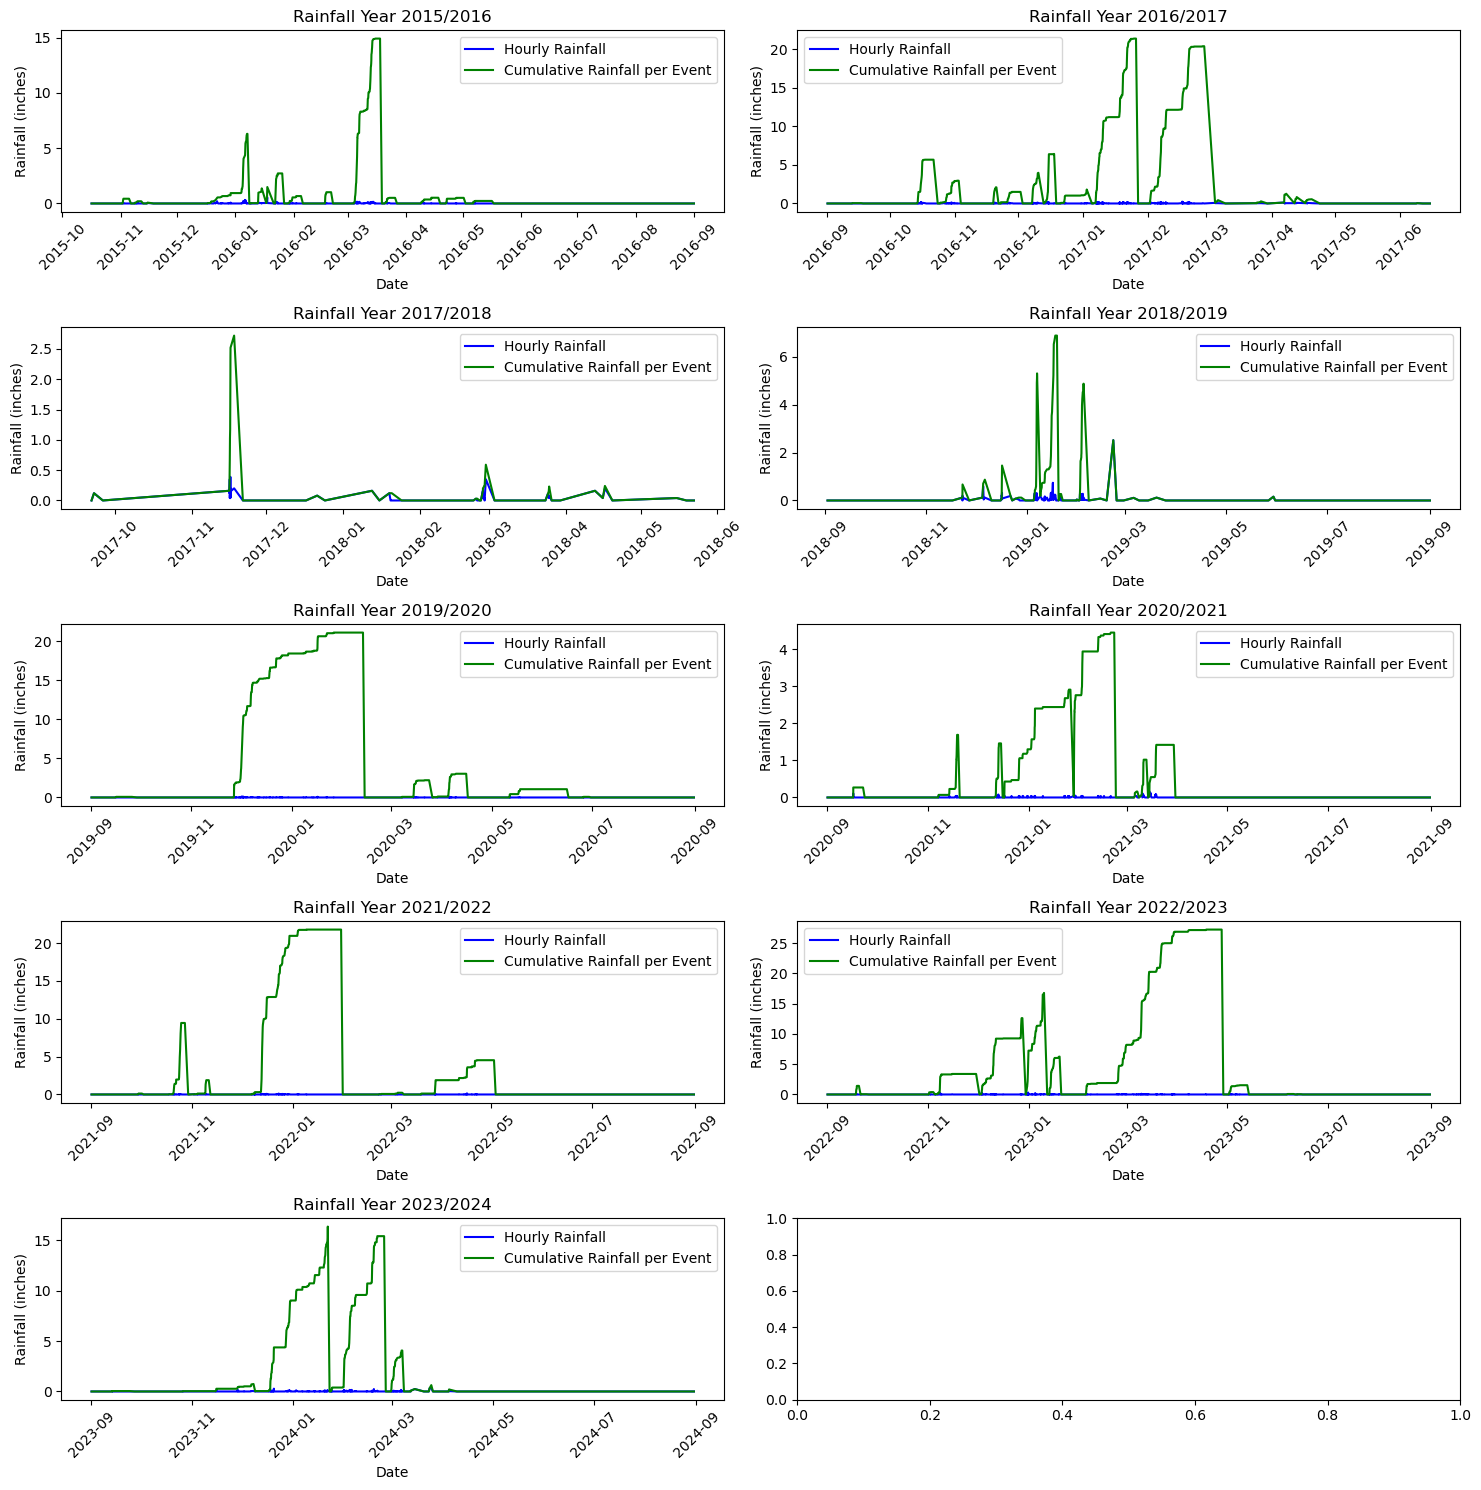

In [86]:
# Prepare the dataset for plotting, similar to the provided example, creating a 'Rainfall Year' and plotting.
# Load the dataset
file_path = 'Outputs/SCH_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv'
rainfall_data = pd.read_csv(file_path)

# Convert 'OBS DATE' to datetime for manipulation
rainfall_data['OBS DATE'] = pd.to_datetime(rainfall_data['OBS DATE'])

# Extract the month and year
rainfall_data['Month'] = rainfall_data['OBS DATE'].dt.month
rainfall_data['Year'] = rainfall_data['OBS DATE'].dt.year

# Create the 'Rainfall Year' column (September to August)
rainfall_data['Rainfall Year'] = rainfall_data['Year']
rainfall_data.loc[rainfall_data['Month'] <= 8, 'Rainfall Year'] -= 1

# Filter out the year 2024/2025 and ensure we only plot up to 08/31/2024
end_date = pd.to_datetime('2024-08-31')
filtered_data = rainfall_data[rainfall_data['OBS DATE'] <= end_date]

# Update the unique years for plotting, ending at 2023/2024
years_to_plot = sorted(filtered_data['Rainfall Year'].unique())

# Define 10 years of data, excluding 2024/2025
years_to_plot = years_to_plot[:9]  # Only select 10 years

# Redefine the number of rows and columns for the 10-year plot
num_cols = 2
num_rows = 5  # 5 years per column

# Create a figure and axis for a page-sized plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot rainfall events for each rainfall year in a two-column layout
for i, year in enumerate(years_to_plot):
    ax = axes[i]
    
    # Filter data for the current rainfall year
    year_data = filtered_data[filtered_data['Rainfall Year'] == year]

    # Plot hourly rainfall
    ax.plot(year_data['OBS DATE'], year_data['Rainfall'], label='Hourly Rainfall', color='blue')

    # Plot cumulative rainfall per event
    ax.plot(year_data['OBS DATE'], year_data['Cumulative Rainfall per Event'], label='Cumulative Rainfall per Event', color='green')

    # Set title and labels for each subplot
    ax.set_title(f'Rainfall Year {year}/{year + 1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rainfall (inches)')
    ax.legend()

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

# Add some space between subplots and make the layout tight
plt.tight_layout()

# Display the final page-sized plot with 10 years of data
plt.show()


Clean Data, check for missing values

In [87]:
# Load the files
file1_path = 'Outputs/transformed_max_flow_data_hourly.csv'
file2_path = 'Outputs/transformed_BLO_rain_data_hourly.csv'
file3_path = 'Outputs/transformed_stream_gage_data_hourly.csv'

# Read the CSV files
max_flow_data = pd.read_csv(file1_path)
rain_data_BLO = pd.read_csv(file2_path)
stream_gage_data = pd.read_csv(file3_path)

# Check for missing date times in each file
missing_max_flow = max_flow_data[max_flow_data.isnull().any(axis=1)]
missing_rain_data_BLO = rain_data_BLO[rain_data_BLO.isnull().any(axis=1)]
missing_stream_gage = stream_gage_data[stream_gage_data.isnull().any(axis=1)]

# Display any rows with missing date times
(missing_max_flow, missing_rain_data_BLO, missing_stream_gage)


(Empty DataFrame
 Columns: [date_hour, discharge]
 Index: [],
       STATION_ID DURATION  SENSOR_NUMBER SENS_TYPE             OBS DATE  \
 1076         BLO        H              2      RAIN  2014-10-15 20:00:00   
 1077         BLO        H              2      RAIN  2014-10-15 21:00:00   
 1078         BLO        H              2      RAIN  2014-10-15 22:00:00   
 1079         BLO        H              2      RAIN  2014-10-15 23:00:00   
 1080         BLO        H              2      RAIN  2014-10-16 00:00:00   
 ...          ...      ...            ...       ...                  ...   
 82615        BLO        H              2      RAIN  2024-02-03 16:00:00   
 82788        BLO        H              2      RAIN  2024-02-10 21:00:00   
 82801        BLO        H              2      RAIN  2024-02-11 10:00:00   
 83465        BLO        H              2      RAIN  2024-03-10 03:00:00   
 84071        BLO        H              2      RAIN  2024-04-04 09:00:00   
 
        VALUE DATA_FLAG 

This tells me only the rain dataset is missing data

In [88]:
# Count the number of missing data rows in the rain dataset
missing_rain_data_count_BLO = rain_data_BLO['VALUE'].isnull().sum()

missing_rain_data_count_BLO


230

Analyze rain data around missing values. Am I missing crucial data?  
I know from the USGS site all of the historic gage heights that have been recorded. The greatest heights recorded during the project time period have been saved into Resources/Max_crest_data.csv

In [89]:
# Filter for all the days that have any missing rain values
missing_days_rain_BLO = rain_data_BLO[rain_data_BLO['VALUE'].isnull()]['OBS DATE'].unique()

# Create a DataFrame with the missing days
missing_days_BLO_df = pd.DataFrame(missing_days_rain_BLO, columns=['OBS DATE'])

# Save the missing days to a CSV file
missing_days_output_path = 'Outputs/missing_rain_days_BLO.csv'
missing_days_BLO_df.to_csv(missing_days_output_path, index=False)

missing_days_output_path


'Outputs/missing_rain_days_BLO.csv'

Compare missing data days with Max Crest Days

In [90]:
# Load the two files
max_crest_data = pd.read_csv('Resources/Max_crest_data.csv')
missing_rain_days_BLO_data = pd.read_csv('Outputs/missing_rain_days_BLO.csv')

# Convert both date columns to datetime
max_crest_data['Date'] = pd.to_datetime(max_crest_data['Date'], errors='coerce')
missing_rain_days_BLO_data['OBS DATE'] = pd.to_datetime(missing_rain_days_BLO_data['OBS DATE'], errors='coerce')

# Compare and find matching dates between the two datasets
matching_dates = max_crest_data[max_crest_data['Date'].isin(missing_rain_days_BLO_data['OBS DATE'])]

matching_dates


,Date,Height (ft)


Check if any missing dates fall within 3 days (before or after) of the max crest dates

In [91]:
# Use timedelta to create a 3-day window for comparison
three_days_window = pd.Timedelta(days=3)

# Compare the missing rain days and max crest days to see if they fall within 3 days of each other
matching_dates_within_3_days = []

for missing_date in missing_rain_days_BLO_data['OBS DATE']:
    for crest_date in max_crest_data['Date']:
        if abs(missing_date - crest_date) <= three_days_window:
            matching_dates_within_3_days.append({'Missing Date': missing_date, 'Crest Date': crest_date})

# Convert the results to a DataFrame
matching_within_3_days_df = pd.DataFrame(matching_dates_within_3_days)

matching_within_3_days_df

,Missing Date,Crest Date
0,2017-01-03 13:00:00,2017-01-04
1,2017-02-09 10:00:00,2017-02-07
2,2023-03-12 03:00:00,2023-03-10
3,2023-03-12 03:00:00,2023-03-14


Just having this noted in case data seems weird later.

In [92]:
# First, let's count the number of missing values per day in the missing rain data
missing_counts_per_day = missing_rain_days_BLO_data['OBS DATE'].dt.date.value_counts()

# Identify days where all 24 hours are missing and days where more than 3 values are missing
completely_missing_days = missing_counts_per_day[missing_counts_per_day == 24]
more_than_3_missing_days = missing_counts_per_day[missing_counts_per_day > 3]

# Create DataFrames for both completely missing days and more than 3 missing days
completely_missing_days_df = pd.DataFrame(completely_missing_days).reset_index().rename(columns={'index': 'OBS Date', 'OBS Date': 'Missing Count'})
more_than_3_missing_days_df = pd.DataFrame(more_than_3_missing_days).reset_index().rename(columns={'index': 'OBS DATE', 'OBS Date': 'Missing Count'})

more_than_3_missing_days_df

,OBS DATE,count
0,2021-07-22,24
1,2014-10-16,24
2,2015-03-19,12
3,2023-09-18,12
4,2023-12-07,11
5,2024-01-30,10
6,2023-12-09,10
7,2014-10-17,9
8,2021-04-18,8
9,2021-07-23,8


Combine all the rainfall data into one file for easier processing

In [93]:

import pandas as pd

# Load the datasets
bcd_data = pd.read_csv('Outputs/BDC_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv')
bln_data = pd.read_csv('Outputs/BLN_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv')
blo_data = pd.read_csv('Outputs/BLO_Processed_Rainfall_Data_with_Events.csv')
sch_data = pd.read_csv('Outputs/SCH_Processed_Rainfall_Data_with_Inserts_Sorted_Final.csv')

# Display the first few rows of each dataset to understand their structures
bcd_data.head(), bln_data.head(), blo_data.head(), sch_data.head()



(  STATION_ID         DATE TIME             OBS DATE  VALUE  \
 0        BDC  2015-10-23 00:52  2015-10-23 00:52:00   0.31   
 1        BDC  2015-10-23 12:52  2015-10-23 12:52:00   0.31   
 2        BDC  2015-10-24 00:52  2015-10-24 00:52:00   0.31   
 3        BDC  2015-10-25 00:52  2015-10-25 00:52:00   0.31   
 4        BDC  2015-10-25 12:52  2015-10-25 12:52:00   0.31   
 
           Rounded Date  Rainfall  Cumulative Daily Rainfall  Event ID  \
 0  2015-10-23 01:00:00       0.0                        0.0         0   
 1  2015-10-23 13:00:00       0.0                        0.0         0   
 2  2015-10-24 01:00:00       0.0                        0.0         0   
 3  2015-10-25 01:00:00       0.0                        0.0         1   
 4  2015-10-25 13:00:00       0.0                        0.0         1   
 
    Cumulative Rainfall per Event  
 0                            0.0  
 1                            0.0  
 2                            0.0  
 3                            

In [94]:
# Clean up and prepare datasets for merging

# Select and rename relevant columns in the BCD dataset
bcd_clean = bcd_data[['Rounded Date', 'Rainfall', 'Cumulative Daily Rainfall', 'Cumulative Rainfall per Event']].copy()
bcd_clean.rename(columns={
    'Rounded Date': 'DateTime',
    'Rainfall': 'BCD_Rainfall',
    'Cumulative Daily Rainfall': 'BCD_Cumulative_Daily_Rainfall',
    'Cumulative Rainfall per Event': 'BCD_Cumulative_Rainfall_per_Event'
}, inplace=True)
bcd_clean['BCD_Station'] = 1  # Indicator column

# Select and rename relevant columns in the BLN dataset
bln_clean = bln_data[['Rounded Date', 'Rainfall', 'Cumulative Daily Rainfall', 'Cumulative Rainfall per Event']].copy()
bln_clean.rename(columns={
    'Rounded Date': 'DateTime',
    'Rainfall': 'BLN_Rainfall',
    'Cumulative Daily Rainfall': 'BLN_Cumulative_Daily_Rainfall',
    'Cumulative Rainfall per Event': 'BLN_Cumulative_Rainfall_per_Event'
}, inplace=True)
bln_clean['BLN_Station'] = 1  # Indicator column

# Select and rename relevant columns in the SCH dataset
sch_clean = sch_data[['Rounded Date', 'Rainfall', 'Cumulative Daily Rainfall', 'Cumulative Rainfall per Event']].copy()
sch_clean.rename(columns={
    'Rounded Date': 'DateTime',
    'Rainfall': 'SCH_Rainfall',
    'Cumulative Daily Rainfall': 'SCH_Cumulative_Daily_Rainfall',
    'Cumulative Rainfall per Event': 'SCH_Cumulative_Rainfall_per_Event'
}, inplace=True)
sch_clean['SCH_Station'] = 1  # Indicator column

# Select and rename relevant columns in the BLO dataset
blo_clean = blo_data[['OBS DATE', 'Hourly Rainfall (inches)', 'Cumulative Daily Rainfall (inches)', 'Cumulative Rainfall per Event (inches)']].copy()
blo_clean.rename(columns={
    'OBS DATE': 'DateTime',
    'Hourly Rainfall (inches)': 'BLO_Rainfall',
    'Cumulative Daily Rainfall (inches)': 'BLO_Cumulative_Daily_Rainfall',
    'Cumulative Rainfall per Event (inches)': 'BLO_Cumulative_Rainfall_per_Event'
}, inplace=True)
blo_clean['BLO_Station'] = 1  # Indicator column

# Merge the datasets on the DateTime column
merged_data = pd.merge(bcd_clean, bln_clean, on='DateTime', how='outer')
merged_data = pd.merge(merged_data, sch_clean, on='DateTime', how='outer')
merged_data = pd.merge(merged_data, blo_clean, on='DateTime', how='outer')

# Fill NaNs in station indicators with 0 to indicate no record for those timestamps
merged_data[['BCD_Station', 'BLN_Station', 'SCH_Station', 'BLO_Station']] = merged_data[['BCD_Station', 'BLN_Station', 'SCH_Station', 'BLO_Station']].fillna(0)

# Fill other NaNs in rainfall columns with 0 as no data
merged_data.fillna(0, inplace=True)

# Save the missing days to a CSV file
missing_days_output_path = 'Outputs/merged_rain_stations.csv'
merged_data.to_csv(missing_days_output_path, index=False)


Combine stream gage data and stream discharge data into one file

In [95]:
# Load the datasets
file_1 = 'Outputs/transformed_max_flow_data_hourly.csv'
file_2 = 'Outputs/transformed_stream_gage_data_hourly.csv'

# Reading both CSV files
df_max_flow = pd.read_csv(file_1)
df_stream_gage = pd.read_csv(file_2)

# Display the first few rows of both datasets to understand their structure
df_max_flow.head(), df_stream_gage.head()


(             date_hour  discharge
 0  2014-09-01 00:00:00       7.09
 1  2014-09-01 01:00:00       7.09
 2  2014-09-01 02:00:00       7.09
 3  2014-09-01 03:00:00       6.86
 4  2014-09-01 04:00:00       6.86,
              date_hour  gage_height
 0  2014-09-01 00:00:00         2.69
 1  2014-09-01 01:00:00         2.69
 2  2014-09-01 02:00:00         2.69
 3  2014-09-01 03:00:00         2.68
 4  2014-09-01 04:00:00         2.68)

In [96]:
# Merging the two datasets on the 'date_hour' column
merged_df = pd.merge(df_max_flow, df_stream_gage, on='date_hour')
# Adding the new column 'NAVD88 ft' by adding 230.06 to each value in the 'gage_height' column
merged_df['NAVD88 ft'] = merged_df['gage_height'] + 230.06

# Saving the updated dataset to a CSV file
output_file = 'Outputs/merged_bigtrees_with_NAVD88.csv'
merged_df.to_csv(output_file, index=False)

merged_df



,date_hour,discharge,gage_height,NAVD88 ft
0,2014-09-01 00:00:00,7.09,2.69,232.75
1,2014-09-01 01:00:00,7.09,2.69,232.75
2,2014-09-01 02:00:00,7.09,2.69,232.75
3,2014-09-01 03:00:00,6.86,2.68,232.74
4,2014-09-01 04:00:00,6.86,2.68,232.74
...,...,...,...,...
87575,2024-09-01 19:00:00,26.40,3.26,233.32
87576,2024-09-01 20:00:00,26.40,3.26,233.32
87577,2024-09-01 21:00:00,26.40,3.26,233.32
87578,2024-09-01 22:00:00,26.40,3.26,233.32


## EDA

In [97]:
# Load the two datasets
file_path_1 = 'Outputs/merged_bigtrees_with_NAVD88.csv'
file_path_2 = 'Outputs/merged_rain_stations.csv'

# Read the CSV files
bigtrees_df = pd.read_csv(file_path_1)
rain_stations_df = pd.read_csv(file_path_2)

# Convert both datetime columns to proper datetime formats
bigtrees_df['date_hour'] = pd.to_datetime(bigtrees_df['date_hour'])
rain_stations_df['DateTime'] = pd.to_datetime(rain_stations_df['DateTime'])

# Merge the two datasets on the datetime columns
merged_df = pd.merge(bigtrees_df, rain_stations_df, left_on='date_hour', right_on='DateTime')

# Drop redundant datetime column
merged_df = merged_df.drop(columns=['DateTime'])

In [98]:
# Calculate correlations between relevant numerical fields
correlation_matrix = merged_df.corr()
print(correlation_matrix)

                                   date_hour  discharge  gage_height  \
date_hour                           1.000000  -0.212758     0.160650   
discharge                          -0.212758   1.000000     0.583846   
gage_height                         0.160650   0.583846     1.000000   
NAVD88 ft                           0.160650   0.583846     1.000000   
BCD_Rainfall                        0.074218   0.190549     0.283375   
BCD_Cumulative_Daily_Rainfall       0.113874   0.409798     0.669812   
BCD_Cumulative_Rainfall_per_Event   0.336368   0.425841     0.696560   
BCD_Station                         0.238010   0.303497     0.535690   
BLN_Rainfall                        0.090193   0.296808     0.442135   
BLN_Cumulative_Daily_Rainfall       0.127200   0.366548     0.668886   
BLN_Cumulative_Rainfall_per_Event   0.250166   0.300941     0.539323   
BLN_Station                         0.258741   0.297308     0.533285   
SCH_Rainfall                        0.090193   0.296808     0.44

In [99]:
# Extract the relevant fields for rainfall event correlations with discharge and gage height
rainfall_event_fields = [
    'discharge', 'gage_height', 'NAVD88 ft',
    'BCD_Cumulative_Rainfall_per_Event', 'BLN_Cumulative_Rainfall_per_Event', 
    'SCH_Cumulative_Rainfall_per_Event', 'BLO_Cumulative_Rainfall_per_Event'
]

# Filter the dataset for the selected fields
rainfall_event_df = merged_df[rainfall_event_fields]

# Calculate the correlation matrix for these fields
rainfall_event_correlation_matrix = rainfall_event_df.corr()

print(rainfall_event_correlation_matrix)


                                   discharge  gage_height  NAVD88 ft  \
discharge                           1.000000     0.583846   0.583846   
gage_height                         0.583846     1.000000   1.000000   
NAVD88 ft                           0.583846     1.000000   1.000000   
BCD_Cumulative_Rainfall_per_Event   0.425841     0.696560   0.696560   
BLN_Cumulative_Rainfall_per_Event   0.300941     0.539323   0.539323   
SCH_Cumulative_Rainfall_per_Event   0.300941     0.539323   0.539323   
BLO_Cumulative_Rainfall_per_Event   0.482269     0.679816   0.679816   

                                   BCD_Cumulative_Rainfall_per_Event  \
discharge                                                   0.425841   
gage_height                                                 0.696560   
NAVD88 ft                                                   0.696560   
BCD_Cumulative_Rainfall_per_Event                           1.000000   
BLN_Cumulative_Rainfall_per_Event                           0.4

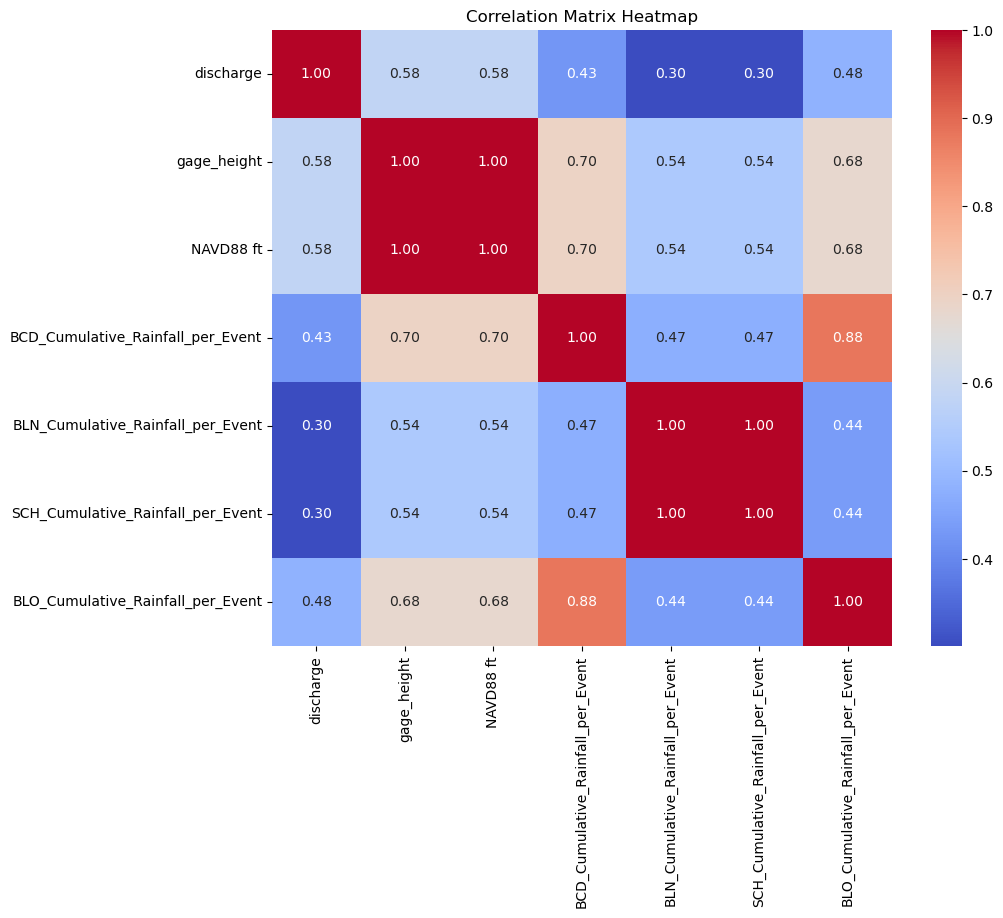

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(rainfall_event_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


## ML

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the features (rainfall event data) and target (discharge)
X = rainfall_event_df[['BCD_Cumulative_Rainfall_per_Event', 'BLN_Cumulative_Rainfall_per_Event', 
                       'SCH_Cumulative_Rainfall_per_Event', 'BLO_Cumulative_Rainfall_per_Event']]
y = rainfall_event_df['discharge']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Predict the discharge values on the test set
y_pred = regression_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients and intercept of the regression model
coefficients = regression_model.coef_
intercept = regression_model.intercept_

mse, r2, coefficients, intercept


(1123033.3836118246,
 0.2427922756764267,
 array([-6.30339381,  6.51152163, 17.07095494, 77.91729379]),
 120.22720794279223)

## Linear Regression Model Results

I built a linear regression model to predict **discharge** based on the cumulative rainfall per event from different stations. Here are the results:

### Model Performance:
- **Mean Squared Error (MSE)**: 1,123,033.38  
  (A lower MSE indicates better model performance, so this value suggests there is room for improvement.)
- **R-squared (R²)**: 0.243  
  (This indicates that about 24% of the variance in discharge can be explained by the rainfall event data in this model. This is relatively low, suggesting the model could be missing other important factors.)

### Model Coefficients:
- **BCD_Cumulative_Rainfall_per_Event**: -6.30  
  (Indicating a slight negative relationship with discharge.)
- **BLN_Cumulative_Rainfall_per_Event**: 6.51  
  (Positive relationship with discharge.)
- **SCH_Cumulative_Rainfall_per_Event**: 17.07  
  (Stronger positive relationship with discharge.)
- **BLO_Cumulative_Rainfall_per_Event**: 77.92  
  (A large positive impact on discharge.)

### Intercept:
- The intercept is 120.23, meaning that when all rainfall events are zero, the model predicts a discharge of about 120.

### Conclusion:
The model has some predictive capability, but with an R² of 0.243, there is significant unexplained variation in discharge, indicating that other factors might be needed to improve the model.


In [102]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict the discharge values on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf


(39754.695212660925, 0.9731953094783857)

## Random Forest Model Results

The Random Forest model has significantly improved performance compared to the linear regression model:

### Model Performance:
- **Mean Squared Error (MSE)**: 39,754.70  
  (This is much lower than the linear regression model's MSE of over 1,123,033, indicating a much better fit.)
- **R-squared (R²)**: 0.973  
  (This means that 97.3% of the variance in discharge can now be explained by the cumulative rainfall events, indicating a very strong fit.)

### Conclusion:
The Random Forest model captures non-linear relationships much better, leading to this substantial improvement in predictive accuracy.
